# Influence in Cinema

Calculate the influence of movies and directors in Cinema.

According to the influence score assigned to each movie, analyse the career of directors, actors and actresses

In [1]:
#import libraries
import os                        # for reading directories
import urllib.request            # for downloading files
import gzip                      # for dealing with gzip files
import re                        # for parsing original files
import pandas as pd              # for csv
import multiprocessing as mp     # for multithread version
import networkx as nx            # for calculating network centralities
import matplotlib.pyplot as plt  # for plots
import collections               # for plotting degree
import seaborn as sns            # for plots
from matplotlib.patches import Rectangle  # for rectangles in the diagonal of heatmap
import math                      # for calculating the career of personalities
import numpy as np               # for calculating the career of personalities

%matplotlib inline

In [2]:
#set directories and other parameters
DATA_DIR = "./data"
IMAGES_DIR = DATA_DIR+"/images"
IMAGES_FORMAT = "eps"

# Analysis on movies

### Download files

In [3]:
def makedir(path):
    if not os.path.exists(path):
        os.makedirs(path)
    return

def download_file(url, filename):
    f = urllib.request.urlopen(url)
    data = f.read()
    with open(filename, "wb") as code:
        code.write(data)
    return

def download_dataset(output_dir="", mirror=True):
    url = "ftp://ftp.fu-berlin.de/pub/misc/movies/database/temporaryaccess/"
    if mirror:
        url = "https://datacloud.di.unito.it/index.php/s/YAJnrYtR5qMEtWq/download?files="
    files = ["movie-links.list.gz", "countries.list.gz", "genres.list.gz"]
    print("Downloading datasets..")
    for fil in files:
        download_file(url+fil, output_dir+"/"+fil)
    print("..done")
    return

def remove_datasets(output_dir=""):
    files = ["movie-links.list.gz", "countries.list.gz", "genres.list.gz"]
    for fil in files:
        os.remove(output_dir+"/"+fil)
    return


In [4]:
makedir(DATA_DIR)
makedir(IMAGES_DIR)

download_dataset(output_dir=DATA_DIR)


..done


## Handle raw data and analyse relations among movies' tags

In [5]:
# get the year of a movie from its title
def get_year_single_movie(title):
    return int(title[-5:-1])

# get dataframe of movie links from gzip file
def get_movie_links(filename):
    regex_movie = re.compile(r'^([^\"][^\(]+ \(\d+\))$')
    regex_links = re.compile(r"\((features|references|follows|spoofs|remake of|spin off from) ([^\"][^\(]+ \(\d+\))\)")
    result = {"movie": [], "cites": []}
    state = 0 # read movie or reference
    movie = ""
    with gzip.open(filename) as f:
        for line in f:
            line = line.decode("ISO-8859-1")
            if state == 0:  # read movie
                res = re.findall(regex_movie, line)
                if res != []:
                    movie = res[0]
                    state = 1
            elif state == 1: # read reference
                if line == "\n":
                    state = 0
                else:
                    res = re.findall(regex_links, line)
                    if res != []:
                        cites = res[0][1]
                        if(get_year_single_movie(movie) >= get_year_single_movie(cites)):
                            result["movie"] += [movie]
                            result["cites"] += [cites]
    return pd.DataFrame(result, columns = ["movie", "cites"])

# get dataframe of movie countries from gzip file
def get_movie_countries(filename):
    regex_movie_country = re.compile(r'^([^\"][^\(]+ \(\d+\))\t+(.+)$')
    result = {"movie": [], "country": []}
    with gzip.open(filename) as f:
        for line in f:
            line = line.decode("ISO-8859-1")
            res = re.findall(regex_movie_country, line)
            if res != []:
                result["movie"] += [res[0][0]]
                result["country"] += [res[0][1]]
    return pd.DataFrame(result, columns = ["movie", "country"])

# get dataframe of movie genres from gzip file
def get_movie_genres(filename):
    regex_movie_genre = re.compile(r'^([^\"][^\(]+ \(\d+\))\t+(.+)$')
    result = {"movie": [], "genre": []}
    with gzip.open(filename) as f:
        for line in f:
            line = line.decode("ISO-8859-1")
            res = re.findall(regex_movie_genre, line)
            if res != []:
                result["movie"] += [res[0][0]]
                result["genre"] += [res[0][1]]
    return pd.DataFrame(result, columns = ["movie", "genre"]) 

#groupby function
def get_grouped(df, y_column, sort_by, ascending):
    return df.groupby(y_column).count().reset_index().sort_values(by = sort_by, ascending = ascending)

#get the dataframe without all the items with the tag in tag_value
def get_df_dropped(df, id_column, tag_column, tag_value):
    local_df = df[df[tag_column] == tag_value][[id_column]]
    local_df["remove"] = True
    local_df = df.merge(local_df, how="left")
    return local_df[local_df["remove"] != True][[id_column,tag_column]]

# save al dataframes
def save_all_dataframes(input_dir="", output_dir="", images_dir=""):
    #read gzip files
    movie_links = get_movie_links(input_dir+"/"+"movie-links.list.gz")
    movie_countries = get_movie_countries(input_dir+"/"+"countries.list.gz")
    movie_genres = get_movie_genres(input_dir+"/"+"genres.list.gz")
    #remove from genres the Short and Adult movies
    movie_genres = get_df_dropped(get_df_dropped(movie_genres, "movie", "genre", "Short"), "movie", "genre", "Adult")
    #select only items that intersect all dataframes
    movie_title = movie_links[["cites"]].drop_duplicates()
    movie_title.columns = ["movie"]
    movie_title = movie_title.append(movie_links[["movie"]].drop_duplicates()).drop_duplicates()
    movie_title = movie_title.merge(movie_countries, how="inner")[["movie"]].drop_duplicates()
    movie_title = movie_title.merge(movie_genres, how="inner")[["movie"]].drop_duplicates()
    #create id for each movie
    movie_title = movie_title.sort_values(by = "movie", ascending = True).reset_index()
    movie_title["id"] = movie_title.index
    movie_title.columns = ["index","title", "id"]
    movie_title = movie_title[["id", "title"]]
    #create dataframe for links
    movie_links = movie_links.merge(movie_title, left_on="movie", right_on="title", how="inner")
    movie_links = movie_links.merge(movie_title, left_on="cites", right_on="title", how="inner", suffixes=["_from", "_to"])[["id_from", "id_to"]]
    movie_links.columns = ["id", "cites"]
    #create dataframe for countries
    movie_countries = movie_countries.merge(movie_title, left_on="movie", right_on="title", how="inner")[["id", "country"]]
    #create dataframe for genres
    movie_genres = movie_genres.merge(movie_title, left_on="movie", right_on="title", how="inner")[["id", "genre"]]
    #create dataframe for years
    movie_year = movie_title.copy()
    movie_year.loc[:,"year"] = movie_year["title"].apply(lambda x: int(x[-5:-1]))
    movie_year = movie_year[["id", "year"]]
    #save dataframes on file
    movie_title.to_csv(output_dir+"/titles.csv", index=False)
    movie_year.to_csv(output_dir+"/years.csv", index=False)
    movie_genres.to_csv(output_dir+"/genres.csv", index=False)
    movie_countries.to_csv(output_dir+"/country.csv", index=False)
    movie_links.to_csv(output_dir+"/links.csv", index=False)
    print("All done!")
    return

 ########################
 #                      #
 #      STATISTICS      #
 #                      #
 ########################

"""
def plot_count_inner(ax, df, x_column, group="id", x_label=None):
    x_label = x_column if x_label == None else x_label
    x_label = "number of "+x_label
    df_local = df.groupby(group).count().reset_index()
    df_local = df_local.groupby(x_column).count().reset_index()
    ax.plot(df_local[x_column], df_local[group], 'o')
    ax.set_yscale('log')
    if max(df_local[x_column]) > 100:
        ax.set_xscale('log')
    ax.set_ylabel("count")
    ax.set_xlabel(x_label)
    return
"""

# plot bar graph
def plot_bars(df, y_column, x_column, x_ticks_step=1, max_value=None):
    if max_value == None:
        plt.bar(range(len(df)), df[x_column])
    else:
        plt.bar(range(len(df)), [(x/float(max_value))*100 for x in df[x_column]])
    plt.xticks(range(0, len(df), x_ticks_step), df[y_column][::x_ticks_step], rotation='vertical')
    #plt.show()
    return

# plot bar grouped
def plot_group_bars(df, y_column, x_column="id", merge_for_labels=None, title="", xlabel="", limit=None, sort_by="id", ascending=False, max_value=None, x_ticks_step=1):
    df_local = get_grouped(df, y_column, sort_by, ascending)
    if limit != None:
        df_local = df_local[:limit]
    if merge_for_labels != None:
        df_local = df_local.merge(merge_for_labels[0], how="left", left_on=y_column, right_on=merge_for_labels[1], suffixes=["","_right"])
        y_column = merge_for_labels[2]
    plot_bars(df_local, y_column, x_column, x_ticks_step=x_ticks_step, max_value=max_value)
    plt.title(title)
    plt.xlabel(xlabel)
    if max_value == None:
        plt.ylabel("count")
    else:
        plt.ylabel("percentage")
    plt.show()
    return

# plot bar grouped
def plot_group_bars_1(df, y_column, x_column="id", title="", xlabel="", xlabel_inner="", limit=None, sort_by="id", ascending=False, max_value=None, x_ticks_step=1, filename=""):
    def plot_count_inner(ax, df, x_column, group="id", x_label=None):
        x_label = x_column if x_label == None else x_label
        x_label = "number of "+x_label
        df_local = df.groupby(group).count().reset_index()
        df_local = df_local.groupby(x_column).count().reset_index()
        ax.plot(df_local[x_column], df_local[group], 'o')
        ax.set_yscale('log')
        if max(df_local[x_column]) > 100:
            ax.set_xscale('log')
        ax.set_ylabel("count")
        ax.set_xlabel(x_label)
        return
    
    fig, ax1 = plt.subplots()
    df_local = get_grouped(df, y_column, sort_by, ascending)
    if limit != None:
        df_local = df_local[:limit]
    plot_bars(df_local, y_column, x_column, x_ticks_step=x_ticks_step, max_value=max_value)
    plt.title(title)
    plt.xlabel(xlabel)
    if max_value == None:
        plt.ylabel("count")
    else:
        plt.ylabel("percentage")
    #plot second graph
    left, bottom, width, height = [0.38, 0.45, 0.5, 0.4]
    ax2 = fig.add_axes([left, bottom, width, height])
    plot_count_inner(ax2, df, y_column, group=x_column, x_label=xlabel_inner)
    #save
    if filename != "":
        plt.savefig(filename, bbox_inches='tight', dpi=160)
    plt.show()
    return

# only for years, plot number of movies by decade
def plot_decades(df_movie_decade, filename=""):
    df = get_grouped(df_movie_decade, "decade", "decade", True)
    plot_bars(df, "decade", "id")
    plt.title("Decades")
    plt.xlabel("decades")
    plt.ylabel("count")
    #save
    if filename != "":
        plt.savefig(filename, bbox_inches='tight', dpi=160)
    plt.show()
    return

"""
def plot_points_inner(ax, df, y_column, x_column, x_label=None):
    x_label = x_column if x_label == None else x_label
    x_label = "number of "+x_label
    ax.plot(df[y_column], df[x_column], 'o')
    ax.set_yscale('log')
    if max(df[x_column]) > 100:
        ax.set_xscale('log')
    ax.set_ylabel("count")
    ax.set_xlabel(x_label)
    return
"""

# plot bar grouped
def plot_group_bars_2(df, y_column, x_column="id", merge_for_labels=None, title="", xlabel="", xlabel_inner="", limit=None, sort_by="id", ascending=False, max_value=None, y_min=None, x_ticks_step=1, filename=""):
    def plot_points_inner(ax, df, y_column, x_column, x_label=None):
        x_label = x_column if x_label == None else x_label
        x_label = "number of "+x_label
        ax.plot(df[y_column], df[x_column], 'o')
        ax.set_yscale('log')
        if max(df[x_column]) > 100:
            ax.set_xscale('log')
        ax.set_ylabel("count")
        ax.set_xlabel(x_label)
        return
    
    fig, ax1 = plt.subplots()
    df_local = get_grouped(df, y_column, sort_by, ascending)
    df_local_2 = df_local.groupby(x_column).count().reset_index()
    if limit != None:
        df_local = df_local[:limit]
    if merge_for_labels != None:
        df_local = df_local.merge(merge_for_labels[0], how="left", left_on=y_column, right_on=merge_for_labels[1], suffixes=["","_right"])
        plot_bars(df_local, merge_for_labels[2], x_column, x_ticks_step=x_ticks_step, max_value=max_value)
    else:
        plot_bars(df_local, y_column, x_column, x_ticks_step=x_ticks_step, max_value=max_value)
    plt.title(title)
    plt.xlabel(xlabel)
    if max_value == None:
        plt.ylabel("count")
    else:
        plt.ylabel("percentage")
    if y_min!=None:
        ax1.set_ylim(y_min, ax1.get_ylim()[1])
    #plot second graph
    left, bottom, width, height = [0.38, 0.45, 0.5, 0.4]
    ax2 = fig.add_axes([left, bottom, width, height])
    plot_points_inner(ax2, df_local_2, x_column, y_column, x_label=xlabel_inner)
    #save
    if filename != "":
        plt.savefig(filename, bbox_inches='tight', dpi=160)
    plt.show()
    return

# get the links between items
def get_item_links(df_links, df_item, from_column, to_column, item_id_column, item_column):
    res = df_links = df_links.merge(df_item, left_on=from_column, right_on=item_id_column)
    return res.merge(df_item, left_on=to_column, right_on=item_id_column)[[item_id_column+"_x", item_column+"_x", item_id_column+"_y", item_column+"_y"]]

# get number of interations between other items
def get_number_interactions(df, id_column, item_column, item_value):
    #calculate number of interations between other items
    res = df[df[item_column] == item_value][[id_column]].merge(df, how="left")
    # delete self item
    res = res[res[item_column] != item_value]
    res = res.groupby(item_column).count().reset_index()
    #calculate times when item is alone
    times = df[df[item_column] == item_value][[id_column]].merge(df, how="left").groupby(id_column).count().reset_index().groupby(item_column).count().reset_index()
    if len(times[times[item_column] == 1][id_column]) != 0:
        res = res.append(pd.DataFrame({item_column: [item_value], id_column: [times[times[item_column] == 1][id_column][0]]}))
    return res.sort_values(by=id_column, ascending=False).reset_index(drop=True)

def get_number_interactions_multi(df, id_column, item_column):
    res = pd.DataFrame(columns=["from", "to", "count"])
    list_of_items = df.groupby(item_column).count().sort_values(by=id_column, ascending=False).reset_index()[item_column]
    for index in range(len(list_of_items)):
        item_value = list_of_items[index]
        number_interactions = get_number_interactions(df, id_column, item_column, item_value)
        number_interactions.columns = ["to", "count"]
        number_interactions["from"] = item_value
        res = res.append(number_interactions)
    return res.reset_index(drop=True)

def get_pivot_interactions_multi(df, id_column, item_column, normalize=True, df_total=pd.DataFrame(), sort_by_total=False):
    res = get_number_interactions_multi(df, id_column, item_column)
    return get_pivot_interactions_multi_self(res, id_column, item_column, normalize=normalize, df_total=df_total, sort_by_total=sort_by_total)

def get_pivot_interactions_multi_self(df, id_column, item_column, normalize=True, df_total=pd.DataFrame(), sort_by_total=False):
    res = df.pivot(index="from", columns="to", values="count").fillna(0).reset_index()
    #calculate percentages
    if normalize:
        if df_total.empty:
            df_total = res.sum(axis=1, numeric_only=True)
            df_total = pd.DataFrame({item_column: res.columns[1:], id_column: df_total})
        else: #sort total by columns
            df_total = res[["from"]].merge(df_total, left_on="from", right_on=item_column)[[item_column, id_column]]
        res = res[res.columns[1:]].div(df_total[id_column].div(100), axis=0)
        res["from"] = res.columns
        res = res[["from"]+res.columns[:-1].tolist()]
        #re-sort df_total
        df_total = df_total.sort_values(by=id_column, ascending=False)
    if sort_by_total:
        if df_total.empty:
            df_total = res.sum(axis=1, numeric_only=True)
            df_total = pd.DataFrame({item_column: res.columns[1:], id_column: df_total}).sort_values(by=id_column, ascending=False)
        res = res.merge(df_total, how="left", left_on="from", right_on=item_column).sort_values(by=id_column, ascending=False).reset_index(drop=True)[["from"]+list(df_total[item_column])]
    return res

def get_pivot_items(df, item_column_from, item_column_to, id_column, df_total=pd.DataFrame(), total_item_column="", total_id_column="", sort_by_total=False):
    if sort_by_total & (not(df_total.empty)):
        list_of_items = list(df_total.sort_values(by=total_id_column, ascending=False)[total_item_column])
    else:
        list_of_items = sorted(list(df[[item_column_from]].drop_duplicates()[item_column_from]))
    res = [[0 for x in range(len(list_of_items))] for y in range(len(list_of_items))]
    divide = 1.0
    for index_x, item_x in enumerate(list_of_items):
        local_df = df[df[item_column_from] == item_x]
        multiply = 1.0 if df_total.empty else 100.0/(df_total[df_total[total_item_column] == item_x][total_id_column].values[0])    
        for index_y, item_y in enumerate(list_of_items):
            res[index_x][index_y] = float(len(local_df[local_df[item_column_to] == item_y].drop_duplicates(subset=[id_column])))*multiply
    res = pd.DataFrame(res, columns=list_of_items)
    res["from"] = list_of_items
    return res[["from"]+list_of_items]

def plot_heatmap(df, filename=""):
    fig = plt.figure(figsize = (8,6))
    ticklabels = df[df.columns[0]].values.tolist()
    ax = sns.heatmap(df[df.columns[1:]], square=1, linewidth=1., vmin=0, vmax=100, xticklabels=ticklabels, yticklabels=ticklabels, cmap="Reds")
    #highlight diagonal values
    number_of_items = len(df)
    for index in range(number_of_items):
        ax.add_patch(Rectangle((index, index), 1, 1, fill=False, edgecolor='silver', lw=2))
    ax.set(title='', xlabel='', ylabel='')
    #save
    if filename != "":
        plt.savefig(filename, bbox_inches='tight', dpi=160)
    plt.show()
    return

# read a list of csv
def load_data(filename_list):
    res = []
    for filename in filename_list:
        res += [pd.read_csv(filename, encoding = "ISO-8859-1")]
    return res

# plot statistics on data
def plot_statistics_on_movies(input_dir="", output_dir="", images_dir=""):
    #load data
    [movie_title, movie_year, movie_genres, movie_countries, movie_links] = load_data([input_dir+"/titles.csv", input_dir+"/years.csv", input_dir+"/genres.csv", input_dir+"/country.csv", input_dir+"/links.csv"])
    #consider only top 30 countries
    movie_countries = movie_countries.merge(movie_countries.groupby("country").count().sort_values("id", ascending=False).reset_index()[:30][["country"]])
    #plot statistics
    len_short_title = 39
    movie_title_short = movie_title.copy()
    movie_title_short.loc[:,"title"] = movie_title_short["title"].apply(lambda x: x if len(x)< len_short_title else (x[:(len_short_title-7)]+".."+x[-7:]))
    print("## count")
    movie_decade = movie_year.copy()#[:]
    movie_decade.loc[:,"decade"] = (movie_decade.loc[:,"year"]//10)*10
    plot_decades(movie_decade, filename=images_dir+"/decades_count."+IMAGES_FORMAT)
    plot_group_bars_1(movie_countries, "country", xlabel="countries", xlabel_inner="countries for a movie", title="Countries", limit=20, max_value=len(movie_year), filename=images_dir+"/countries_count."+IMAGES_FORMAT)
    plot_group_bars_1(movie_genres, "genre", xlabel="genres", xlabel_inner="genres for a movie", title="Genres", max_value=len(movie_year), filename=images_dir+"/genres_count."+IMAGES_FORMAT)
    print("## citations")
    plot_group_bars_2(movie_links, "cites", xlabel="movies", xlabel_inner="citations", title="Most Cited", limit=20, merge_for_labels=[movie_title_short, "id", "title"], y_min=200, filename=images_dir+"/most_referenced."+IMAGES_FORMAT)
    plot_group_bars_2(movie_links, "id", x_column="cites", xlabel="movies", xlabel_inner="citations", title="Most Citing", limit=20, sort_by="cites", merge_for_labels=[movie_title_short, "id", "title"], y_min=180, filename=images_dir+"/most_referencing."+IMAGES_FORMAT)
    movie_year["year"] = [int(x/10)*10 for x in movie_year["year"]]
    for item, item_df, sort_by_total in [("genre", movie_genres, True), ("country", movie_countries, True), ("year", movie_year, False)]:
        print("## Statistic on "+item)
        if (item != "year"):
            print("How much a "+item+" is used as a tag for a movie with other ones, divided by total number of movies in a "+item+".")
            print(" - diagonal counts how much a "+item+" is used alone.")
            item_count = item_df.groupby(item).count().sort_values("id", ascending=False).reset_index()
            #use item_count as df_total because on diagonal there are the number of tags alone!!
            plot_heatmap(get_pivot_interactions_multi(item_df, "id", item, df_total=item_count, sort_by_total=True), filename=images_dir+"/"+item+"_relations."+IMAGES_FORMAT)
        link_items = get_item_links(movie_links, item_df, "id", "cites", "id", item)
        print("How much a "+item+" references the other ones, divided by total number of movies in a "+item+" that makes at least one reference")
        number_of_citing_movies = link_items[["id_x", item+"_x"]].drop_duplicates().groupby(item+"_x").count().sort_values(by="id_x", ascending=False).reset_index()
        plot_heatmap(get_pivot_items(link_items, item+"_x", item+"_y", "id_x", df_total=number_of_citing_movies, total_item_column=item+"_x", total_id_column="id_x", sort_by_total=sort_by_total), filename=images_dir+"/"+item+"_references."+IMAGES_FORMAT)
        print("How much a "+item+" is referenced by the other ones, divided by total number of movies in a "+item+" that receives at least one reference")
        number_of_cited_movies = link_items[["id_y", item+"_y"]].drop_duplicates().groupby(item+"_y").count().sort_values(by="id_y", ascending=False).reset_index()
        plot_heatmap(get_pivot_items(link_items, item+"_y", item+"_x", "id_y", df_total=number_of_cited_movies, total_item_column=item+"_y", total_id_column="id_y", sort_by_total=sort_by_total), filename=images_dir+"/"+item+"_referenced."+IMAGES_FORMAT)
    print("All done!")
    return


In [6]:
#create data from raw, and delete downloaded data
save_all_dataframes(input_dir=DATA_DIR, output_dir=DATA_DIR, images_dir=IMAGES_DIR)
remove_datasets(output_dir=DATA_DIR)


All done!


## count


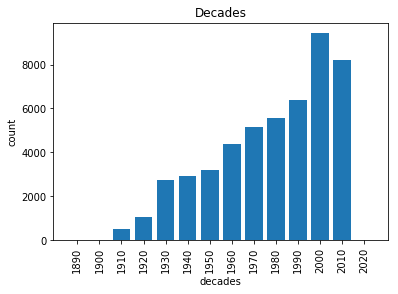

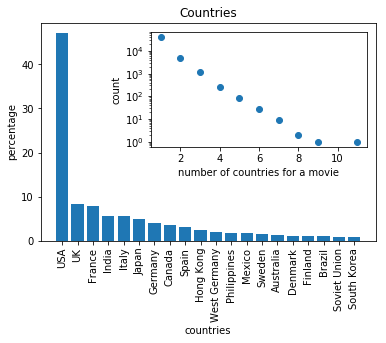

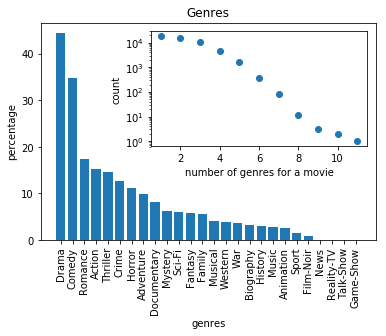

## citations


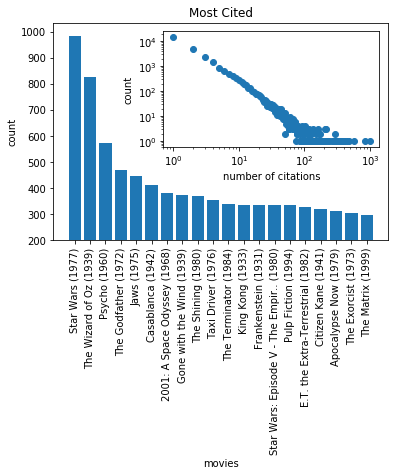

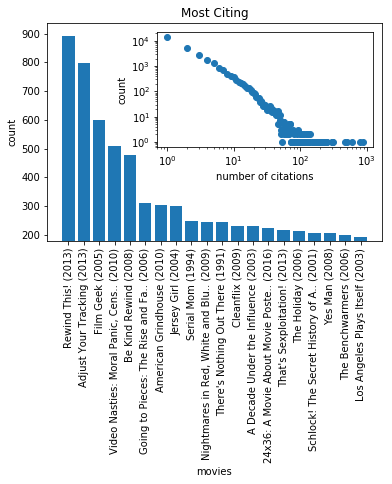

## Statistic on genre
How much a genre is used as a tag for a movie with other ones, divided by total number of movies in a genre.
 - diagonal counts how much a genre is used alone.


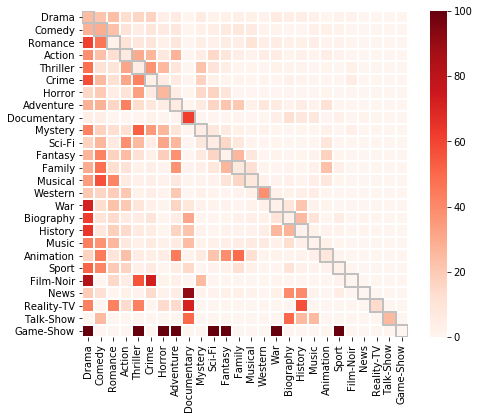

How much a genre references the other ones, divided by total number of movies in a genre that makes at least one reference


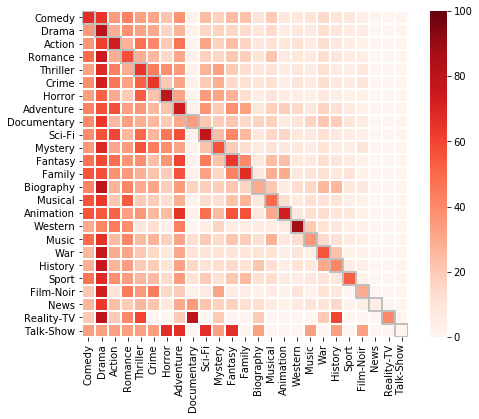

How much a genre is referenced by the other ones, divided by total number of movies in a genre that receives at least one reference


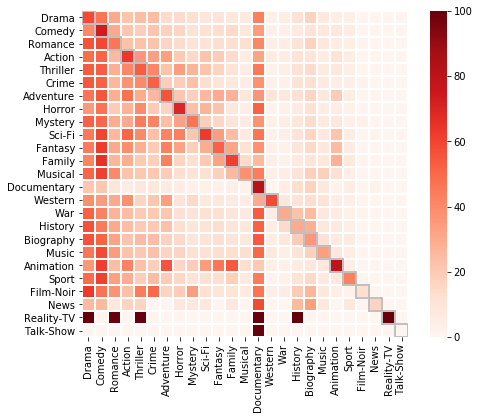

## Statistic on country
How much a country is used as a tag for a movie with other ones, divided by total number of movies in a country.
 - diagonal counts how much a country is used alone.


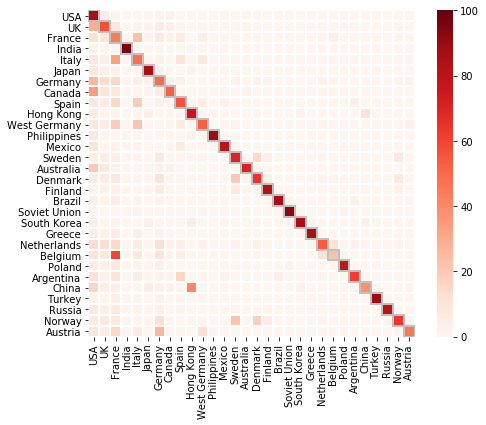

How much a country references the other ones, divided by total number of movies in a country that makes at least one reference


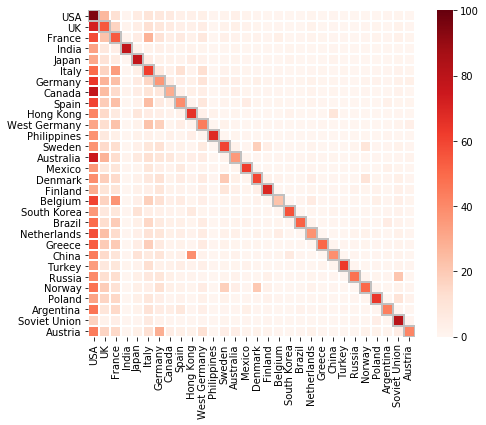

How much a country is referenced by the other ones, divided by total number of movies in a country that receives at least one reference


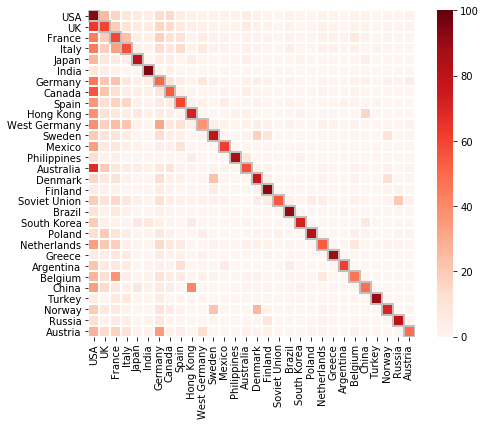

## Statistic on year
How much a year references the other ones, divided by total number of movies in a year that makes at least one reference


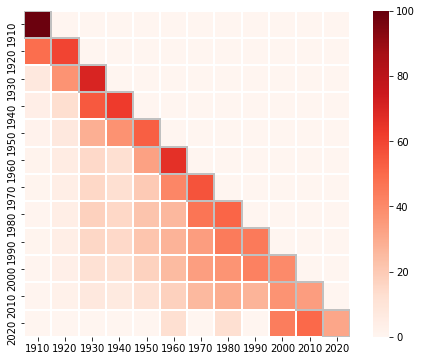

How much a year is referenced by the other ones, divided by total number of movies in a year that receives at least one reference


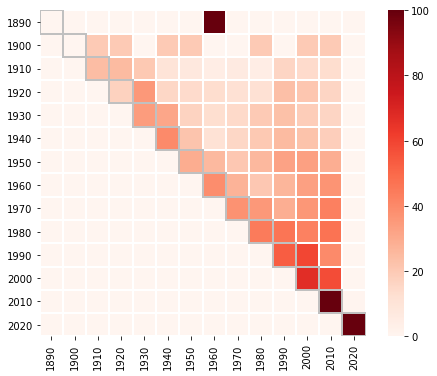

All done!


In [7]:
#plot statistics on data
plot_statistics_on_movies(input_dir=DATA_DIR, output_dir=DATA_DIR, images_dir=IMAGES_DIR)

## Calculate influence score for movies

In [8]:
"""
Parallel processing
"""

def get_harmonic_centrality_parallel_func(G, item_list, frm, length, return_dict):
    local_item_list = item_list[frm: min(len(item_list),(frm+length))]
    res = nx.harmonic_centrality(G, nbunch=local_item_list)
    for item in local_item_list:
        return_dict[item] = res[item]
    return

def get_harmonic_centrality_parallel(G, item_list=None, num_threads=0):
    if num_threads == 0:
        num_threads = mp.cpu_count()
    if item_list == None:
        item_list = list(G.nodes())
    # number of items for each thread
    # in python 3, the result of a division is a float!!
    delta = len(item_list)/float(num_threads)
    if (delta).is_integer():
        delta = int(delta)
    else:
        delta = int(delta) + 1
        
    manager = mp.Manager()
    return_dict = manager.dict()

    jobs = []
    for thread in range(num_threads):
        p = mp.Process(target=get_harmonic_centrality_parallel_func, args=(G, item_list, thread*delta, delta, return_dict))
        jobs.append(p)
        p.start()

    for proc in jobs:
        proc.join()
    return return_dict.items()

def get_closeness_centrality(G, node):
    return nx.closeness_centrality(G, u=node)

def get_centrality_parallel_func(G, centrality_func, item_list, frm, length, return_dict):
    for item in item_list[frm: min(len(item_list),(frm+length))]:
        return_dict[item] = centrality_func(G, item)
    return

def get_centrality_parallel(G, centrality_func, item_list=None, num_threads=0):
    if num_threads == 0:
        num_threads = mp.cpu_count()
    if item_list == None:
        item_list = list(G.nodes())
    # number of items for each thread
    # in python 3, the result of a division is a float!!
    delta = len(item_list)/float(num_threads)
    if (delta).is_integer():
        delta = int(delta)
    else:
        delta = int(delta) + 1
        
    manager = mp.Manager()
    return_dict = manager.dict()

    jobs = []
    for thread in range(num_threads):
        p = mp.Process(target=get_centrality_parallel_func, args=(G, centrality_func, item_list, thread*delta, delta, return_dict))
        jobs.append(p)
        p.start()

    for proc in jobs:
        proc.join()
        
    return_dict = dict(return_dict)
    return return_dict.items()

def normalize_pairs(list_of_pairs):
    max_value = float(max([value for key,value in list_of_pairs]))
    return [(key,value/max_value) for key,value in list_of_pairs]

def calculate_and_save_centralities(input_file, output_file):
    df = pd.read_csv(input_file)
    #G = nx.from_pandas_dataframe(df, df.columns[0], df.columns[1], create_using=nx.DiGraph())
    G = nx.from_pandas_edgelist(df, df.columns[0], df.columns[1], create_using=nx.DiGraph())
    print("Calculating in-degree centrality...")
    df = pd.DataFrame(normalize_pairs(nx.in_degree_centrality(G).items()), columns=[df.columns[0], "in_degree"])
    print("Calculating closeness centrality...")
    df = df.merge(pd.DataFrame(normalize_pairs(get_centrality_parallel(G, get_closeness_centrality)), columns=[df.columns[0], "closeness"]))
    print("Calculating harmonic centrality...")
    df = df.merge(pd.DataFrame(normalize_pairs(get_harmonic_centrality_parallel(G)), columns=[df.columns[0], "harmonic"]))
    print("Calculating pagerank centrality...")
    df = df.merge(pd.DataFrame(normalize_pairs(nx.pagerank(G).items()), columns=[df.columns[0], "pagerank"]))
    #calculate total centrality
    print("Calculating aggregated centrality...")
    df["influence"] = df[df.columns[1:]].sum(axis=1)/float(len(df.columns[1:]))
    df = df.sort_values(by="influence", ascending=False).reset_index(drop=True)
    #save on file
    print("Saving centralities...")
    df.to_csv(output_file, index=False)
    print("...all done!")
    return
    

In [9]:
# calculate all centrality scores, and save on file
calculate_and_save_centralities(DATA_DIR+"/links.csv", DATA_DIR+"/centralities.csv")

Calculating in-degree centrality...
Calculating closeness centrality...
Calculating harmonic centrality...
Calculating pagerank centrality...
Calculating aggregated centrality...
Saving centralities...
...all done!


In [10]:
# print basic analysis on network of links between movies
def analyse_network(input_file):
    df = pd.read_csv(input_file)
    #G = nx.from_pandas_dataframe(df, df.columns[0], df.columns[1], create_using=nx.DiGraph())
    G = nx.from_pandas_edgelist(df, df.columns[0], df.columns[1], create_using=nx.DiGraph())
    print(G.number_of_nodes(), "nodes")
    print(G.number_of_edges(), "edges")
    print(nx.number_weakly_connected_components(G), "weakly connected components")
    largest = max(nx.weakly_connected_component_subgraphs(G),key=len)
    print(largest.number_of_nodes(), "nodes (","{0:.2f}".format((largest.number_of_nodes()/float(G.number_of_nodes())*100)),"%) on greatest weakly connected component")
    print(largest.number_of_edges(), "edges (","{0:.2f}".format((largest.number_of_edges()/float(G.number_of_edges())*100)),"%) on greatest weakly connected component")
    print("##### UNDIRECTED VERSION ####")
    H = G.to_undirected()
    print(nx.average_clustering(H), "average clustering")
    return 

analyse_network(DATA_DIR+"/links.csv")

47266 nodes
129657 edges
4410 weakly connected components
36321 nodes ( 76.84 %) on greatest weakly connected component
119729 edges ( 92.34 %) on greatest weakly connected component
##### UNDIRECTED VERSION ####
0.14744967787332056 average clustering


## Analyze influence score

In [11]:
# read list of csv about movies
def load_data_movies(input_dir):
    return load_data([input_dir+"/titles.csv", input_dir+"/centralities.csv", input_dir+"/years.csv", input_dir+"/genres.csv", input_dir+"/country.csv"])

def get_grouped(df, y_column, sort_by, ascending):
    return df.groupby(y_column).count().reset_index().sort_values(by = sort_by, ascending = ascending)

def get_rank_sorted(titles_csv, centralities_csv, year_csv, genres_csv, countries_csv, by="influence", countries_list=[], genres_list=[], years_list=[]):
    num_col_centralities = len(centralities_csv.columns)
    res = centralities_csv.merge(titles_csv)
    res = res[["title"]+list(res.columns[1:num_col_centralities])+["id"]]
    if countries_list != []:
        res = res.merge(countries_csv[countries_csv["country"].isin(countries_list)])
    if genres_list != []:
        res = res.merge(genres_csv[genres_csv["genre"].isin(genres_list)])
    if years_list != []:
        res = res.merge(year_csv[year_csv["year"].isin(years_list)])
    return res[res.columns].drop_duplicates().sort_values(by=by, ascending=False)

def plot_errorbars(df, xlabel="", ylabel="", filename=""):
    plt.errorbar(range(len(df["mean"])), df["mean"], yerr=df["std"])
    plt.yscale('log')
    plt.xticks(range(len(df["mean"])), df["xlabels"], rotation='vertical')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #save
    if filename != "":
        plt.savefig(filename, bbox_inches='tight', dpi=160)
    plt.show()
    return

In [12]:
#get data on movies saved in the analysis section
[movie_title, movie_centralities, movie_year, movie_genres, movie_countries] = load_data_movies(DATA_DIR)
movie_centralities["rank"] = 1+movie_centralities.index
print(len(movie_centralities), "movies on dataset")

47266 movies on dataset


#### Top ranking - general

In [13]:
#print top ranking of most influential movies
top_rank = 20
print("Most influential "+str(top_rank)+" movies of all times")
get_rank_sorted(movie_title, movie_centralities, movie_year, movie_genres, movie_countries)[:top_rank].merge(movie_countries.groupby("id")["country"].apply(list).reset_index())


Most influential 20 movies of all times


,title,in_degree,closeness,harmonic,pagerank,influence,rank,id,country
0,The Wizard of Oz (1939),0.838710,1.000000,1.000000,1.000000,0.959677,1,44307,[USA]
1,Star Wars (1977),1.000000,0.785030,0.786888,0.643051,0.803742,2,36878,[USA]
2,Psycho (1960),0.575442,0.921031,0.911381,0.570532,0.744597,3,31874,[USA]
3,King Kong (1933),0.332986,0.937890,0.896142,0.549242,0.679065,4,20743,[USA]
4,2001: A Space Odyssey (1968),0.385016,0.886674,0.852325,0.395545,0.629890,5,272,"[UK, USA]"
5,Metropolis (1927),0.135276,0.976659,0.938045,0.448135,0.624529,6,26198,[Germany]
6,Citizen Kane (1941),0.327784,0.865652,0.853938,0.355482,0.600714,7,7433,[USA]
7,The Birth of a Nation (1915),0.067638,0.910514,0.838395,0.568781,0.596332,8,39145,[USA]
8,Frankenstein (1931),0.340271,0.816968,0.806945,0.405681,0.592466,9,13807,[USA]
9,Snow White and the Seven Dwarfs (1937),0.178980,0.875344,0.831177,0.424060,0.577390,10,36158,[USA]


#### Top ranking - by classes (decade, genre, country)

In [14]:
#calculate and print top ranking of most influential movies by decade
def top_movies_by_decade(top_size):
    result = {"mean": [], "std": [], "xlabels": []}
    for starting_year in range(1890, 2020, 10):
        print("\n## Years", starting_year, "-", (starting_year+9), "##")
        temp = get_rank_sorted(movie_title, movie_centralities, movie_year, movie_genres, movie_countries, years_list=range(starting_year, starting_year+10))[:top_size][["title","rank"]]
        print(temp)
        temp = temp["rank"]
        result["xlabels"] += [str(starting_year)+"-"+str(starting_year+9)]
        result["mean"] += [temp.mean()]
        result["std"] += [temp.std()]
    result = pd.DataFrame(result, columns = ["mean", "std", "xlabels"])
    plot_errorbars(result, xlabel="decades of release", ylabel="average ranking", filename=IMAGES_DIR+"/ranking_decades."+IMAGES_FORMAT)
    return

#calculate and print top ranking of most influential movies by genre
def top_movies_by_genre(top_size):
    result = {"mean": [], "std": [], "xlabels": []}
    for genre in get_grouped(movie_genres, "genre", "id", False)[:20]["genre"]:
        print("\n## Genre: ", genre, "##")
        temp = get_rank_sorted(movie_title, movie_centralities, movie_year, movie_genres, movie_countries, genres_list=[genre])[:top_size][["title","rank"]]
        print(temp)
        temp = temp["rank"]
        result["xlabels"] += [genre]
        result["mean"] += [temp.mean()]
        result["std"] += [temp.std()]
    result = pd.DataFrame(result, columns = ["mean", "std", "xlabels"])
    plot_errorbars(result.sort_values(by = "mean", ascending = True), xlabel="genres", ylabel="average ranking", filename=IMAGES_DIR+"/ranking_genres."+IMAGES_FORMAT)
    return

#calculate and print top ranking of most influential movies by country
def top_movies_by_country(top_size):
    result = {"mean": [], "std": [], "xlabels": []}
    for country in get_grouped(movie_countries, "country", "id", False)[:20]["country"]:
        print("\n## Country: ", country, "##")
        #print(get_rank_sorted(movie_title, movie_centralities, movie_year, movie_genres, movie_countries, countries_list=[country])[:top_size][["title","rank"]])
        #temp = get_rank_sorted(movie_title, movie_centralities, movie_year, movie_genres, movie_countries, countries_list=[country])[:top_size]["rank"]
        temp = get_rank_sorted(movie_title, movie_centralities, movie_year, movie_genres, movie_countries, countries_list=[country])[:top_size][["title","rank"]]
        print(temp)
        temp = temp["rank"]
        result["xlabels"] += [country]
        result["mean"] += [temp.mean()]
        result["std"] += [temp.std()]
    result = pd.DataFrame(result, columns = ["mean", "std", "xlabels"])
    plot_errorbars(result.sort_values(by = "mean", ascending = True), xlabel="countries", ylabel="average ranking", filename=IMAGES_DIR+"/ranking_countries."+IMAGES_FORMAT)


Most influential 10 movies by decade

## Years 1890 - 1899 ##
                                  title   rank
0  The Corbett-Fitzsimmons Fight (1897)  16684

## Years 1900 - 1909 ##
                          title   rank
0     Robbery Under Arms (1907)   9000
1         Locura de amor (1909)  14908
2      The Life of Moses (1909)  16961
3     Westinghouse Works (1904)  24570
4  Den lille hornblÃ¦ser (1909)  25280

## Years 1910 - 1919 ##
                                               title  rank
0                       The Birth of a Nation (1915)     8
1                                     Cabiria (1914)    17
2                   The Poor Little Rich Girl (1917)    45
3  Intolerance: Love's Struggle Throughout the Ag...    53
4                          Tarzan of the Apes (1918)   122
5                       The Romance of Tarzan (1918)   134
6            His Majesty, the Scarecrow of Oz (1914)   138
7                                   Der Golem (1915)   235
8                            

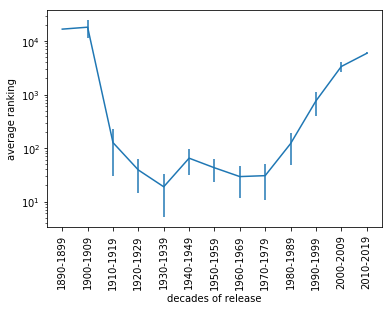

In [15]:
#print top ranking of most influential movies by decade
top_size = 10

print("Most influential", top_size, "movies by decade")

top_movies_by_decade(top_size)

Most influential 10 movies by genre

The dataset contains 108093 'genre' entries, divided into 26 tags

## Genre:  Drama ##
                          title  rank
0             Metropolis (1927)     6
1           Citizen Kane (1941)     7
2  The Birth of a Nation (1915)     8
3           Frankenstein (1931)     9
4             Casablanca (1942)    11
5          The Godfather (1972)    13
6                   Jaws (1975)    14
7          The Searchers (1956)    16
8                Cabiria (1914)    17
9     Gone with the Wind (1939)    19

## Genre:  Comedy ##
                                               title  rank
0  Dr. Strangelove or: How I Learned to Stop Worr...    18
1                         Singin' in the Rain (1952)    24
2                            La rÃ¨gle du jeu (1939)    30
3                               La dolce vita (1960)    36
4                            The Wizard of Oz (1925)    42
5                             Sh! The Octopus (1937)    44
6                   The

                                    title  rank
0                    The Searchers (1956)    16
1  Il buono, il brutto, il cattivo (1966)    31
2                       Stagecoach (1939)    39
3                            Greed (1924)    50
4                        Oklahoma! (1955)    71
5                    Johnny Guitar (1954)    76
6                      The General (1926)    82
7                        High Noon (1952)    85
8         She Wore a Yellow Ribbon (1949)    86
9            The Magnificent Seven (1960)    89

## Genre:  War ##
                                 title  rank
0         The Birth of a Nation (1915)     8
1                    Casablanca (1942)    11
2                       Cabiria (1914)    17
3            Gone with the Wind (1939)    19
4            La grande illusion (1937)    38
5           Triumph des Willens (1935)    46
6                     Spartacus (1960)    52
7  The Bridge on the River Kwai (1957)    55
8               The Lost Patrol (1934)    60
9  

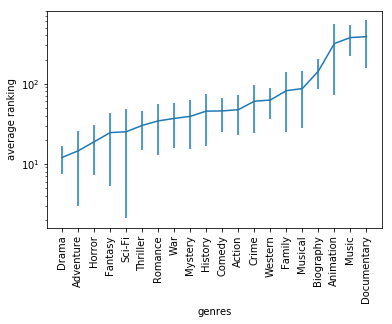

In [16]:
#print top ranking of most influential movies by genre
top_size = 10

print("Most influential", top_size, "movies by genre")
print("\nThe dataset contains "+str(len(movie_genres))+" 'genre' entries, divided into "+str(len(movie_genres[["genre"]].drop_duplicates()))+" tags")

top_movies_by_genre(top_size)

Most influential 10 movies by country

The dataset contains 59822 'country' entries, divided into 157 tags

## Country:  USA ##
                                    title  rank
0                 The Wizard of Oz (1939)     1
1                        Star Wars (1977)     2
2                           Psycho (1960)     3
3                        King Kong (1933)     4
4            2001: A Space Odyssey (1968)     5
5                     Citizen Kane (1941)     7
6            The Birth of a Nation (1915)     8
7                     Frankenstein (1931)     9
8  Snow White and the Seven Dwarfs (1937)    10
9                       Casablanca (1942)    11

## Country:  UK ##
                                               title  rank
0                       2001: A Space Odyssey (1968)     5
1  Dr. Strangelove or: How I Learned to Stop Worr...    18
2                          A Clockwork Orange (1971)    21
3                                      Dr. No (1962)    25
4                            

                                               title  rank
0                           La vie de bohÃ¨me (1992)  5481
1                              Uuno Turhapuro (1973)  5489
2                          L.A. Without a Map (1998)  5496
3                              Pekka PuupÃ¤Ã¤ (1953)  5747
4              Professori Uuno D.G. Turhapuro (1975)  5799
5                 Lottovoittaja UKK Turhapuro (1976)  5891
6  HÃ¤py endkÃ¶? Eli kuinka Uuno Turhapuro sai ni...  6121
7              Pekka PuupÃ¤Ã¤ kesÃ¤laitumilla (1953)  6189
8  Rautakauppias Uuno Turhapuro, presidentin vÃ¤v...  6262
9                  Uuno Turhapuron aviokriisi (1981)  6386

## Country:  Brazil ##
                                        title  rank
0             Kiss of the Spider Woman (1985)  1891
1   O Estranho Mundo de ZÃ© do CaixÃ£o (1968)  4297
2  Os TrapalhÃµes e o MÃ¡gico de OrÃ³z (1984)  4367
3                             Anaconda (1997)  5899
4                       Cidade de Deus (2002)  5901
5       Deus e 

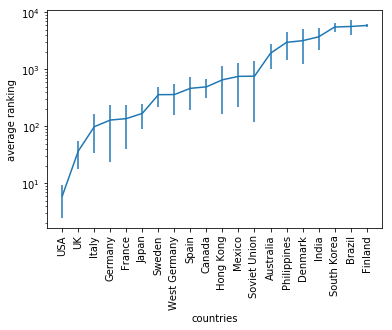

In [17]:
#print top ranking of most influential movies by country
top_size = 10

print("Most influential", top_size, "movies by country")
print("\nThe dataset contains "+str(len(movie_countries))+" 'country' entries, divided into "+str(len(movie_countries[["country"]].drop_duplicates()))+" tags")

top_movies_by_country(top_size)

### Validation of influence score
Presence of top American movies in two rankings:
- US Library of Congresss National Film Registry (NFR)
- 100 best American movies by the American Film Institute (AFI)

In [18]:
def get_rank_list(titles_csv, centralities_csv, year_csv, genres_csv, countries_csv, by="influence", titles_list=[], show_all=True, countries_list=[], genres_list=[], years_list=[]):
    local_rank = get_rank_sorted(titles_csv, centralities_csv, year_csv, genres_csv, countries_csv, by=by, countries_list=countries_list, genres_list=genres_list, years_list=years_list)[["title","rank", by]]
    local_rank.loc[:,"local_rank"] = local_rank[[by]].rank(method="min", ascending=False).values
    columns_to_show = ["title", "local_rank"]
    if titles_list != []:
        not_in_list = list(set(titles_list).difference(local_rank["title"]))
        if not_in_list != []:
            print(len(not_in_list), "elements (over "+str(len(titles_list))+") not in list")
        if show_all:
            local_rank.loc[:,"in_list"] = local_rank["title"].isin(titles_list)
            columns_to_show = ["title", "local_rank", "in_list"]
        else:
            local_rank = local_rank[local_rank["title"].isin(titles_list)].reset_index(inplace=True)
        return [not_in_list, local_rank[columns_to_show]]
    return local_rank[columns_to_show]

def print_movies_in_list(titles_csv, centralities_csv, year_csv, genres_csv, countries_csv, titles_list, top_k, get_list=False, by="influence", countries_list=[], genres_list=[], years_list=[]):
    [not_in_list, res] = get_rank_list(titles_csv, centralities_csv, year_csv, genres_csv, countries_csv, titles_list=titles_list, countries_list=countries_list, genres_list=genres_list, years_list=years_list)
    res = res.sort_values(by="local_rank")[:top_k]
    print(res["in_list"].values.tolist().count(True), "elements over", top_k, "in list")
    if get_list:
        return res
    return

def download_validation_lists(output_dir=""):
    url = "https://datacloud.di.unito.it/index.php/s/YAJnrYtR5qMEtWq/download?files="
    files = ["NFR.csv", "AFI.csv"]
    print("Downloading lists..")
    for fil in files:
        download_file(url+fil, output_dir+"/"+fil)
    print("..done")
    return


In [19]:
top_k = 25

download_validation_lists(output_dir=DATA_DIR)

..done


In [20]:
print("Presence of top "+str(top_k)+" movies in US Library of Congresss National Film Registry (NFR)\n")
print_movies_in_list(movie_title, movie_centralities, movie_year, movie_genres, movie_countries, pd.read_csv(DATA_DIR+"/NFR.csv", delimiter="\t")["title"].values.tolist(), top_k, get_list=True, countries_list=["USA"])


Presence of top 25 movies in US Library of Congresss National Film Registry (NFR)

249 elements (over 703) not in list
21 elements over 25 in list


,title,local_rank,in_list
0,The Wizard of Oz (1939),1.0,True
1,Star Wars (1977),2.0,True
2,Psycho (1960),3.0,True
3,King Kong (1933),4.0,True
4,2001: A Space Odyssey (1968),5.0,True
5,Citizen Kane (1941),6.0,True
6,The Birth of a Nation (1915),7.0,True
7,Frankenstein (1931),8.0,True
8,Snow White and the Seven Dwarfs (1937),9.0,True
9,Casablanca (1942),10.0,True


In [21]:
top_k = 25

print("Presence of top "+str(top_k)+" movies in 100 best American movies by the American Film Institute (AFI)\n")
print_movies_in_list(movie_title, movie_centralities, movie_year, movie_genres, movie_countries, pd.read_csv(DATA_DIR+"/AFI.csv", delimiter="\t")["title"].values.tolist(), top_k, get_list=True, countries_list=["USA"])


Presence of top 25 movies in 100 best American movies by the American Film Institute (AFI)

1 elements (over 123) not in list
19 elements over 25 in list


,title,local_rank,in_list
0,The Wizard of Oz (1939),1.0,True
1,Star Wars (1977),2.0,True
2,Psycho (1960),3.0,True
3,King Kong (1933),4.0,True
4,2001: A Space Odyssey (1968),5.0,True
5,Citizen Kane (1941),6.0,True
6,The Birth of a Nation (1915),7.0,True
7,Frankenstein (1931),8.0,True
8,Snow White and the Seven Dwarfs (1937),9.0,True
9,Casablanca (1942),10.0,True


## Handle raw data on directors

In [22]:
DIR_CEN_DATA_DIR = DATA_DIR+"/director_centralities"
makedir(DIR_CEN_DATA_DIR)


In [23]:
 ########################
 #                      #
 #   HANDLE RAW DATA    #
 #                      #
 ########################
    
def download_person_dataset(output_dir="", mirror=True):
    url = "ftp://ftp.fu-berlin.de/pub/misc/movies/database/frozendata/"
    if mirror:
        url = "https://datacloud.di.unito.it/index.php/s/QYfTXr05ElHum9q/download?files="
    files = ["directors.list.gz", "actresses.list.gz", "actors.list.gz"]
    print("Downloading datasets..")
    
    for fil in files:
        download_file(url+fil, output_dir+"/"+fil)
    print("..done")
    return

def remove_person_datasets(output_dir=""):
    files = ["directors.list.gz", "actresses.list.gz", "actors.list.gz"]
    for fil in files:
        os.remove(output_dir+"/"+fil)
    return

#Calculate csv from IMDB data

def get_movie_director(filename):
    string_movie = r'[^\"][^\(]+ \(\d+\))(?! \(.+\)| \{\{SUSPENDED\}\})(?:\s*\(uncredited\))?'
    regex_director_only_movie = re.compile(r'\t+([^\t\"]'+string_movie)
    regex_director_movie = re.compile(r'(.+[^\t])\t+(.+)$')
    regex_movie = re.compile(r'^('+string_movie)
    
    result = {"movie": [], "person": []} 
    state = 0 # read director + movie or only movie
    person = ""
    with gzip.open(filename) as f:
        for line in f:
            line = line.decode("ISO-8859-1")
            if state == 0:  # read director + movie
                res = re.findall(regex_director_movie, line)
                if res != []:
                    #print res[0]
                    person = res[0][0]
                    state = 1
                    # add first movie, if it's a movie
                    res = re.findall(regex_movie, res[0][1])
            elif state == 1: # read reference
                if line == "\n" or line[:4] == "----": #---- is for avoiding the first column
                    state = 0
                    res = []
                else:
                    res = re.findall(regex_director_only_movie, line)
            if res != []:
                result["person"] += [person]
                result["movie"] += [res[0]]
    return pd.DataFrame(result, columns = ["movie", "person"]) # result

def get_movie_actor(filename):
    #string_movie = r'[^\"][^\(]+ \(\d+\))(?! \(| \{)'
    #string_movie = r'[^\"][^\(]+ \(\d+\))(?! \(.+\)| \{\{SUSPENDED\}\})'
    string_movie = r'[^\"][^\(]+ \(\d+\))(?! \(.+\)| \{\{SUSPENDED\}\})(?:\s*\(uncredited\))?\s*(?:\[(.+)\])?\s*(?:<(\d+)>)?'
    regex_actor_only_movie = re.compile(r'\t+([^\t\"]'+string_movie)
    regex_actor_movie = re.compile(r'(.+[^\t])\t+(.+)$')
    regex_movie = re.compile(r'^('+string_movie)
    
    result = { "movie": [], "person": [],"character": [], "position_in_credits": []} 
    state = 0 # read director + movie or only movie
    person = ""
    with gzip.open(filename) as f:
        for line in f:
            line = line.decode("ISO-8859-1")
            if state == 0:  # read director + movie
                res = re.findall(regex_actor_movie, line)
                if res != []:
                    #print res[0]
                    person = res[0][0]
                    state = 1
                    # add first movie, if it's a movie
                    res = re.findall(regex_movie, res[0][1])
            elif state == 1: # read reference
                if line == "\n" or line[:4] == "----": #---- is for avoiding the first column
                    state = 0
                    res = []
                else:
                    res = re.findall(regex_actor_only_movie, line)
            if res != []:
                result["movie"] += [res[0][0]]
                result["person"] += [person]
                result["character"] += [res[0][1]]
                result["position_in_credits"] += [res[0][2]]
    return pd.DataFrame(result, columns = ["movie", "person", "character", "position_in_credits"])


# save al dataframes
def save_all_person_dataframes(df_movies, input_dir="", output_dir=""):
    #read movies
    #movie_title = pd.read_csv(movie_title_filename)
    for func, input_file, output_file in zip([get_movie_director, get_movie_actor, get_movie_actor],["directors.list.gz", "actresses.list.gz", "actors.list.gz"],["directors.csv", "actresses.csv", "actors.csv"]):
        #read gzip files
        res = df_movies.merge(func(input_dir+"/"+input_file), left_on="title", right_on="movie")
        #save dataframes on file
        res.to_csv(output_dir+"/"+output_file, index=False, columns = ["id", "person"]+list(res.columns[4:]), sep=';')
    return

 ########################
 #                      #
 #     ASSIGN TAGS      #
 #                      #
 ########################

#get dataframe with the number of movie of each person
def get_person_movies_count(csv_person, csv_2):
    temp = csv_2.merge(csv_person).groupby(["person","id"]).count().reset_index()[["person","id"]]
    temp = temp.groupby(["person"]).count().reset_index()
    temp.columns = ["person","movies"]
    return temp

#get dataframe with the years of first and last movie of each person
def get_person_years(csv_person, csv_years):
    temp = csv_years.merge(csv_person)[["person","year"]].groupby("person").agg(["min", "max", "count"]).reset_index()
    temp.columns = ["person", "year_from", "year_to", "number_of_movies"]
    return temp

#get dataframe that count the number of tags faced by each person in career
def get_person_tags_count(csv_person, csv_tags, tag):
    temp = csv_tags.merge(csv_person).groupby(["person",tag]).count().reset_index()
    temp.columns = ["person", tag, "count"]
    return temp

#get dataframe containing all the items where the count over total is greater than the given threshold
def get_person_tag_threshold(csv_aggregate, threshold, count_column="count"):
    df = csv_aggregate[["person", count_column]].groupby("person").sum().reset_index()
    df.columns = ["person", "total"]
    df = csv_aggregate.merge(df)
    df = df[df["count"] >= threshold*df["total"]]
    return df

#get dataframe containing for each person the max count and 
#all the tags where the count over total is greater than the given threshold
def get_person_top_tag(csv_aggregate, threshold, count_column="count"):
    df = get_person_tag_threshold(csv_aggregate, threshold, count_column=count_column)
    return df[df.columns[:-1]].append(csv_aggregate.sort_values(by=["person","count"]).groupby("person").last().reset_index()).sort_values(by=["person","count"]).drop_duplicates()

#calculate all the tags associated to a person
def get_person_top_tags():
    movie_directors = pd.read_csv(DATA_DIR+"/directors.csv", delimiter=";")
    #years of activity
    get_person_years(movie_directors, movie_year).to_csv(DIR_CEN_DATA_DIR+"/year.csv", index=False)
    #genres
    get_person_tags_count(movie_directors, movie_genres, "genre").to_csv(DIR_CEN_DATA_DIR+"/all_genres.csv", index=False)
    get_person_top_tag(get_person_tags_count(movie_directors, movie_genres, "genre"), 0.3).to_csv(DIR_CEN_DATA_DIR+"/genres.csv", index=False)
    #countries
    get_person_tags_count(movie_directors, movie_countries, "country").to_csv(DIR_CEN_DATA_DIR+"/all_countries.csv", index=False)
    get_person_top_tag(get_person_tags_count(movie_directors, movie_countries, "country"), 0.3).to_csv(DIR_CEN_DATA_DIR+"/countries.csv", index=False)
    return

In [24]:
download_person_dataset(output_dir=DATA_DIR)
print("Handle raw data..")
save_all_person_dataframes(pd.read_csv(DATA_DIR+"/titles.csv"), input_dir=DATA_DIR, output_dir=DATA_DIR)
remove_person_datasets(output_dir=DATA_DIR)

print("Assign tags to directors..")
get_person_top_tags()

print("..all done!")

..done
Handle raw data..
Assign tags to directors..
..all done!


## Calculate influence score for directors

In [25]:
#get dataframe containing links between persons
#a link means that a person has been involved in a movie that cites a movies the other person has been involved
def get_person_links(csv_person, csv_movie_links):
    links = csv_movie_links.merge(csv_person)
    links = links.merge(csv_person, left_on="cites", right_on="id", suffixes = ["", "_cites"])
    links = links[["person", "person_cites"]]
    links.columns = ["person", "cites"]
    #delete self citations
    links = links[links["person"] != links["cites"]]
    #delete repetitions
    links.drop_duplicates(inplace=True)
    return links

movie_directors = pd.read_csv(DATA_DIR+"/directors.csv", delimiter=";")
get_person_links(movie_directors, pd.read_csv(DATA_DIR+"/links.csv")).to_csv(DIR_CEN_DATA_DIR+"/links.csv", index=False)


In [26]:
calculate_and_save_centralities(DIR_CEN_DATA_DIR+"/links.csv", DIR_CEN_DATA_DIR+"/centralities.csv")


Calculating in-degree centrality...
Calculating closeness centrality...
Calculating harmonic centrality...
Calculating pagerank centrality...
Calculating aggregated centrality...
Saving centralities...
...all done!


## Analyze influence score for directors

In [27]:
def load_data_directors(input_dir):
    return load_data([input_dir+"/centralities.csv", input_dir+"/year.csv", input_dir+"/genres.csv", input_dir+"/countries.csv"])

[dir_centralities, dir_years, dir_genres, dir_countries] = load_data_directors(DIR_CEN_DATA_DIR)
dir_centralities["rank"] = dir_centralities["influence"].rank(ascending=False, method="min")

#### Top ranking - general

In [28]:
#print top ranking of most influential directors
top_rank = 20
print("Most influential "+str(top_rank)+" directors of all times")
dir_centralities.merge(dir_centralities[["person"]].merge(dir_years, how="left")).sort_values(by=["rank","person"], ascending=True)[:top_rank]


Most influential 20 directors of all times


,person,in_degree,closeness,harmonic,pagerank,influence,rank,year_from,year_to,number_of_movies
0,"Cukor, George",0.870120,1.000000,1.000000,1.000000,0.967530,1.0,1930,1981,45
1,"Fleming, Victor (I)",0.815315,0.983769,0.985978,0.943096,0.932040,2.0,1920,1948,22
2,"Hitchcock, Alfred (I)",0.808559,0.976761,0.982398,0.858217,0.906484,3.0,1925,1976,47
3,"LeRoy, Mervyn",0.661411,0.967720,0.963176,0.890904,0.870803,4.0,1928,1968,45
4,"Spielberg, Steven",1.000000,0.874236,0.937855,0.592964,0.851263,5.0,1964,2020,33
5,"Kubrick, Stanley",0.885135,0.922799,0.959356,0.625502,0.848198,6.0,1953,1999,13
6,"Taurog, Norman",0.604354,0.951781,0.947383,0.749948,0.813367,7.0,1930,1968,55
7,"Vidor, King",0.605105,0.956707,0.950317,0.732886,0.811254,8.0,1921,1959,27
8,"Lucas, George (I)",0.853604,0.853038,0.901459,0.511717,0.779955,9.0,1969,2005,7
9,"Curtiz, Michael",0.492492,0.933797,0.922737,0.685346,0.758593,10.0,1922,1961,77


#### Top ranking - by classes (decade, genre, country)

In [29]:
def get_rank_sorted(centralities_csv, year_csv, genres_csv, countries_csv, by="influence", countries_list=[], genres_list=[], years_range=[]):
    res = centralities_csv
    if countries_list != []:
        res = res.merge(countries_csv[countries_csv["country"].isin(countries_list)])
    if genres_list != []:
        res = res.merge(genres_csv[genres_csv["genre"].isin(genres_list)])
    if years_range != []:
        res = res.merge(year_csv[(year_csv["year_from"] <= years_range[0]) & (year_csv["year_to"] >= years_range[0]) |
                                (year_csv["year_from"] <= years_range[1]) & (year_csv["year_to"] >= years_range[1])])
    return res[res.columns[:7]].drop_duplicates().sort_values(by=by, ascending=False)

#calculate and print top ranking of most influential directors by decade
def top_directors_by_decade(top_size):
    result = {"mean": [], "std": [], "xlabels": []}
    for starting_year in range(1910, 2020, 10):
        print("\n## Years", starting_year, "-", (starting_year+9), "##")
        print(get_rank_sorted(dir_centralities, dir_years, dir_genres, dir_countries, years_range=range(starting_year, starting_year+10))[:top_size][["person","rank"]])
        temp = get_rank_sorted(dir_centralities, dir_years, dir_genres, dir_countries, years_range=range(starting_year, starting_year+10))[:top_size]["rank"]
        result["xlabels"] += [str(starting_year)+"-"+str(starting_year+9)]
        result["mean"] += [temp.mean()]
        result["std"] += [temp.std()]
    result = pd.DataFrame(result, columns = ["mean", "std", "xlabels"])
    plot_errorbars(result, xlabel="decades of release", ylabel="average ranking", filename=IMAGES_DIR+"/ranking_decades."+IMAGES_FORMAT)
    return

#calculate and print top ranking of most influential directors by genre
def top_directors_by_genre(top_size):
    result = {"mean": [], "std": [], "xlabels": []}
    for genre in get_grouped(movie_genres, "genre", "id", False)[:20]["genre"]:
        print("\n## Genre:", genre, "##")
        print(get_rank_sorted(dir_centralities, dir_years, dir_genres, dir_countries, genres_list=[genre])[:top_size][["person","rank"]])
        temp = get_rank_sorted(dir_centralities, dir_years, dir_genres, dir_countries, genres_list=[genre])[:top_size]["rank"]
        result["xlabels"] += [genre]
        result["mean"] += [temp.mean()]
        result["std"] += [temp.std()]
    result = pd.DataFrame(result, columns = ["mean", "std", "xlabels"])
    plot_errorbars(result.sort_values(by = "mean", ascending = True), xlabel="genres", ylabel="average ranking", filename=IMAGES_DIR+"/ranking_genres."+IMAGES_FORMAT)
    return

#calculate and print top ranking of most influential directors by country
def top_directors_by_country(top_size):
    result = {"mean": [], "std": [], "xlabels": []}
    for country in get_grouped(movie_countries, "country", "id", False)[:20]["country"]:
        print("\n## Country:", country, "##")
        print(get_rank_sorted(dir_centralities, dir_years, dir_genres, dir_countries, countries_list=[country])[:top_size][["person","rank"]])
        temp = get_rank_sorted(dir_centralities, dir_years, dir_genres, dir_countries, countries_list=[country])[:top_size]["rank"]
        result["xlabels"] += [country]
        result["mean"] += [temp.mean()]
        result["std"] += [temp.std()]
    result = pd.DataFrame(result, columns = ["mean", "std", "xlabels"])
    plot_errorbars(result.sort_values(by = "mean", ascending = True), xlabel="countries", ylabel="average ranking", filename=IMAGES_DIR+"/ranking_countries."+IMAGES_FORMAT)
    return


Most influential 10 directors by decade

## Years 1910 - 1919 ##
                 person    rank
0      Guazzoni, Enrico  1197.0
1   Blackton, J. Stuart  1801.0
2  de Liguoro, Giuseppe  2240.0
3       Padovan, Adolfo  2272.0
4  Bertolini, Francesco  2272.0
5          Turner, Otis  3411.0
6    BaÃ±os, Ricardo de  4070.0
7    Bednarczyk, Antoni  5133.0
8            Gad, Urban  8677.0

## Years 1920 - 1929 ##
                person  rank
0  Fleming, Victor (I)   2.0
1          Vidor, King   8.0
2        Wood, Sam (I)  15.0
3       Ford, John (I)  28.0
4         Murnau, F.W.  30.0
5        Browning, Tod  31.0
6      Lang, Fritz (I)  32.0
7         Walsh, Raoul  37.0
8   Griffith, D.W. (I)  45.0
9      Brenon, Herbert  51.0

## Years 1930 - 1939 ##
                  person  rank
0          Cukor, George   1.0
1    Fleming, Victor (I)   2.0
2  Hitchcock, Alfred (I)   3.0
3          LeRoy, Mervyn   4.0
4         Taurog, Norman   7.0
5            Vidor, King   8.0
6        Curtiz, Michael  10.

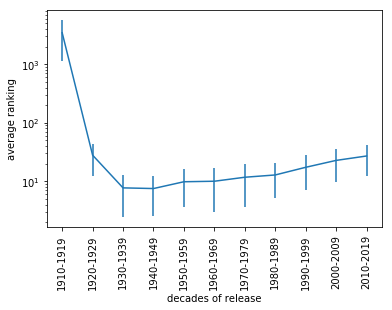

In [30]:
#print top ranking of most influential directors by decade
top_size = 10

print("Most influential", top_size, "directors by decade")

top_directors_by_decade(top_size)

Most influential 10 directors by genre

## Genre: Drama ##
                  person  rank
0          Cukor, George   1.0
1    Fleming, Victor (I)   2.0
2          LeRoy, Mervyn   4.0
3      Spielberg, Steven   5.0
4       Kubrick, Stanley   6.0
5            Vidor, King   8.0
6        Curtiz, Michael  10.0
7       Whale, James (I)  11.0
8  Coppola, Francis Ford  12.0
9          Wood, Sam (I)  15.0

## Genre: Comedy ##
                 person   rank
0        Taurog, Norman    7.0
1         Wilder, Billy   18.0
2          Capra, Frank   25.0
3      Zemeckis, Robert   40.0
4      Chaplin, Charles   59.0
5       Lubitsch, Ernst   82.0
6  Marshall, George (I)   90.0
7      Landis, John (I)   97.0
8    Edwards, Blake (I)  105.0
9   Sidney, George (II)  107.0

## Genre: Romance ##
                  person   rank
0         Van Dyke, W.S.   29.0
3          Pearce, Perce   53.0
1           Morey, Larry   53.0
2  Cottrell, William (I)   53.0
4         Donen, Stanley   57.0
5     Minnelli, Vincente

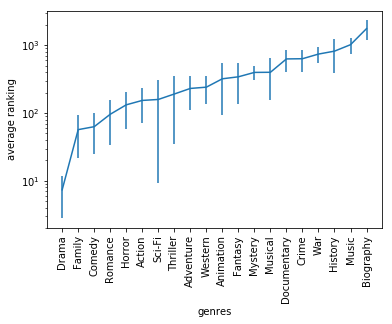

In [31]:
#print top ranking of most influential directors by genre
top_size = 10

print("Most influential", top_size, "directors by genre")

top_directors_by_genre(top_size)

Most influential 10 directors by country

## Country: USA ##
                  person  rank
0          Cukor, George   1.0
1    Fleming, Victor (I)   2.0
2  Hitchcock, Alfred (I)   3.0
3          LeRoy, Mervyn   4.0
4      Spielberg, Steven   5.0
5       Kubrick, Stanley   6.0
6         Taurog, Norman   7.0
7            Vidor, King   8.0
8      Lucas, George (I)   9.0
9        Curtiz, Michael  10.0

## Country: UK ##
                  person   rank
0  Hitchcock, Alfred (I)    3.0
1       Kubrick, Stanley    6.0
2          Scott, Ridley   21.0
3        Lean, David (I)   48.0
4      Hamilton, Guy (I)   68.0
5         Young, Terence   89.0
6        Reed, Carol (I)  106.0
7    Powell, Michael (I)  115.0
8         Gilliam, Terry  129.0
9   Korda, Alexander (I)  137.0

## Country: France ##
                   person   rank
0     Polanski, Roman (I)   39.0
1       Fellini, Federico   49.0
2        Godard, Jean-Luc   75.0
3     Truffaut, FranÃ§ois   85.0
4            Renoir, Jean   87.0
5     

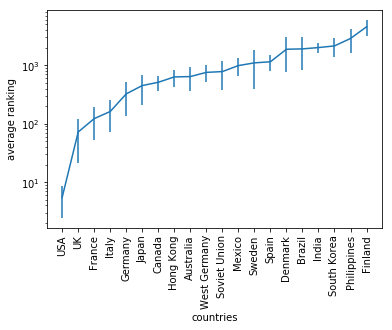

In [32]:
#print top ranking of most influential directors by country
top_size = 10

print("Most influential", top_size, "directors by country")

top_directors_by_country(top_size)

# Career of personalities

In [33]:
#order the ids by order_by_column, and for each tag in tag_column select the items in range in_range
def get_top_range(df, tag_column, order_by_column, in_range, id_column="id"):
    res = pd.DataFrame(columns=[id_column,tag_column])
    for tag in sorted(df[tag_column].unique()):
        tmp = df[df[tag_column] == tag].sort_values(by=order_by_column, ascending=False)
        res = res.append(tmp[math.ceil(len(tmp)*in_range[0]):math.ceil(len(tmp)*in_range[1])][[id_column,tag_column]])
    return res.reset_index(drop=True)

#for each id, get the top percentage in ranges. For each id in the top i^th range, assign i to a column "level"
def get_top_ranges(df, tag_column, order_by_column, ranges, id_column="id"):
    res = pd.DataFrame(columns=[id_column,tag_column, "level"])
    for index in range(len(ranges)-1):
        tmp = get_top_range(df, tag_column, order_by_column, ranges[index: index+2])
        tmp["level"] = index+1
        res = res.append(tmp)
    return res.sort_values(by=[tag_column, "level"], ascending=True).drop_duplicates(subset=[id_column, tag_column]).reset_index(drop=True)

#add to movies a list of genres and countries of production
def get_movies_overview(df_centralities, df_year, df_genres, df_countries):
    df_decade = df_year.copy()
    df_decade.loc[:,"decade"] = (df_decade.loc[:,"year"]//10)*10
    df = df_centralities.merge(df_decade)
    df = df.merge(df_genres.groupby("id")["genre"].apply(list).reset_index())
    df = df.merge(df_countries.groupby("id")["country"].apply(list).reset_index())
    return df

#unwind column: if a column contains a list, create a new item for each value of the list
def unwind(df, column_id, column_to_unwind):
    rows = []
    df.apply(lambda row: [rows.append([row[column_id], nn]) for nn in row[column_to_unwind]], axis=1)
    return df.drop(column_to_unwind, axis=1).merge(pd.DataFrame(rows, columns=[column_id, column_to_unwind]))

#calculate top ranges
def get_career_rank(df_top, df_to_rank, rank_column, column_to_rank, id_column="id", pivot_on=None):
    if pivot_on == None:
        return df_top[[id_column, rank_column]].merge(df_to_rank).groupby([column_to_rank, rank_column]).count().reset_index().pivot(index=column_to_rank, columns=rank_column, values=id_column).reset_index().fillna(0).sort_values(by=[1, 2, column_to_rank], ascending=False)
    return pd.pivot_table(df_top[[id_column, rank_column, pivot_on]].merge(df_to_rank).groupby([column_to_rank, pivot_on, rank_column]).count().reset_index(), 
        values=id_column, index=[column_to_rank, pivot_on], columns=[rank_column], aggfunc=np.sum).reset_index().fillna(0).sort_values(by=[1, 2, column_to_rank], ascending=False)


In [34]:
#limits of top influential movies by year
rank_limits = [0, 0.05, 0.1, 0.15]  # level 1: top 5%; level 2: top 5-10%; level 3: top 10-15%
list_of_levels = [x for x in range(1,len(rank_limits))]


### Directors

In [35]:
#read data on directors
movie_directors = pd.read_csv(DATA_DIR+"/directors.csv", delimiter=";")
[movie_title, movie_centralities, movie_year, movie_genres, movie_countries] = load_data_movies(DATA_DIR)

print("The dataset contains "+str(len(movie_directors[["person"]].drop_duplicates()))+" directors, that creates "+str(len(movie_directors))+" connections with movies")

#read data on movies
movies_overview = get_movies_overview(movie_centralities, movie_year, movie_genres, movie_countries)

#get top influential movies of each year
top_ranges = get_top_ranges(movies_overview[movies_overview["year"] < 2010], "year", "influence",rank_limits).merge(movies_overview[["id", "decade", "genre", "country"]])


The dataset contains 22100 directors, that creates 55502 connections with movies


#### Top careers - general

In [36]:
print("Best directors on the basis of career")

get_career_rank(top_ranges, movie_directors, "level", "person", id_column="id", pivot_on=None).merge(dir_years, how="left").sort_values(by=list_of_levels+["number_of_movies"], ascending=([False]*(len(rank_limits)-1))+[True]).reset_index(drop=True)


Best directors on the basis of career


,person,1,2,3,year_from,year_to,number_of_movies
0,"Hitchcock, Alfred (I)",22.0,9.0,4.0,1925.0,1976.0,47.0
1,"Spielberg, Steven",18.0,3.0,2.0,1964.0,2020.0,33.0
2,"De Palma, Brian",14.0,5.0,0.0,1968.0,2012.0,29.0
3,"Hawks, Howard",12.0,4.0,3.0,1927.0,1970.0,39.0
4,"Ford, John (I)",12.0,4.0,2.0,1917.0,1966.0,59.0
5,"Scorsese, Martin (I)",11.0,6.0,2.0,1967.0,2014.0,33.0
6,"Bergman, Ingmar",11.0,2.0,1.0,1946.0,1986.0,33.0
7,"Kubrick, Stanley",11.0,1.0,1.0,1953.0,1999.0,13.0
8,"Thomas, Gerald (I)",11.0,1.0,1.0,1958.0,1992.0,33.0
9,"Honda, Ishirô",10.0,8.0,2.0,NaN,NaN,NaN


#### Top careers - by classes (decade, genre, country)

In [37]:
def top_directors_career_by_decade(top_size):
    tmp = get_career_rank(top_ranges, movie_directors, "level", "person", id_column="id", pivot_on="decade")
    for starting_year in range(1910, 2010, 10):
        print("\n## Years", starting_year, "-", (starting_year+9),"##")
        print(tmp[tmp["decade"] == starting_year].drop("decade", axis=1).merge(dir_years, how="left").sort_values(by=list_of_levels+["number_of_movies"], ascending=([False]*(len(rank_limits)-1))+[True])[:top_size])
    return

def top_directors_career_by_genre(top_size):
    tmp = get_career_rank(unwind(top_ranges, "id", "genre"), movie_directors, "level", "person", id_column="id", pivot_on="genre")
    for genre in get_grouped(movie_genres, "genre", "id", False)[:20]["genre"]:
        print("\n## Genre: ", genre)
        inner_top_ranges = unwind(top_ranges, "id", "genre")
        inner_years = get_person_years(inner_top_ranges[inner_top_ranges["genre"] == genre][["id","year"]], movie_directors) #dir_years
        print(tmp[tmp["genre"] == genre].drop("genre", axis=1).merge(inner_years, how="left").sort_values(by=list_of_levels+["person"], ascending=False)[:top_size])
    return

def top_directors_career_by_country(top_size):
    tmp = get_career_rank(unwind(top_ranges, "id", "country"), movie_directors, "level", "person", id_column="id", pivot_on="country")
    for country in get_grouped(movie_countries, "country", "id", False)[:20]["country"]:
        print("\n## Country: ", country)
        inner_top_ranges = unwind(top_ranges, "id", "country")
        inner_years = get_person_years(inner_top_ranges[inner_top_ranges["country"] == country][["id","year"]], movie_directors) #dir_years
        print(tmp[tmp["country"] == country].drop("country", axis=1).merge(inner_years, how="left").sort_values(by=list_of_levels+["person"], ascending=False)[:top_size])
    return


In [38]:
#print top ranking of best directors on the basis of career by decade
top_size = 10

print("Best", top_size, "directors on the basis of career by decade")
top_directors_career_by_decade(top_size)


Best 10 directors on the basis of career by decade

## Years 1910 - 1919 ##
                   person    1    2    3  year_from  year_to  number_of_movies
0      Griffith, D.W. (I)  3.0  0.0  0.0     1914.0   1930.0              17.0
1         Brenon, Herbert  2.0  1.0  1.0     1914.0   1938.0              22.0
5      Edwards, J. Gordon  2.0  0.0  1.0     1916.0   1923.0               9.0
3      Pastrone, Giovanni  2.0  0.0  0.0     1914.0   1918.0               3.0
4   MacDonald, J. Farrell  2.0  0.0  0.0     1914.0   1914.0               3.0
2           Wegener, Paul  2.0  0.0  0.0     1913.0   1936.0               5.0
6        Feuillade, Louis  1.0  4.0  1.0     1913.0   1921.0              15.0
7         Samuelson, G.B.  1.0  1.0  0.0     1918.0   1918.0               2.0
8        Cabanne, Christy  1.0  1.0  0.0     1912.0   1947.0              25.0
13             Plumb, Hay  1.0  0.0  0.0     1913.0   1913.0               1.0

## Years 1920 - 1929 ##
                   person    1

In [39]:
#print top ranking of best directors on the basis of career by genre
top_size = 10

print("Best", top_size, "directors on the basis of career by genre")
top_directors_career_by_genre(top_size)

Best 10 directors on the basis of career by genre

## Genre:  Drama
                  person     1    2    3  year_from  year_to  number_of_movies
0        Bergman, Ingmar  11.0  2.0  1.0       1949     1978                14
1   Scorsese, Martin (I)  10.0  4.0  2.0       1967     2006                16
2       Kubrick, Stanley   9.0  1.0  1.0       1953     1999                11
3  Hitchcock, Alfred (I)   8.0  3.0  1.0       1927     1969                12
4        Kurosawa, Akira   7.0  4.0  3.0       1943     1993                14
5          Welles, Orson   7.0  2.0  2.0       1941     1992                11
6      Spielberg, Steven   7.0  2.0  1.0       1975     2005                10
7        De Palma, Brian   7.0  2.0  0.0       1968     2006                 9
8          Hawks, Howard   7.0  1.0  2.0       1930     1967                10
9          LeRoy, Mervyn   6.0  4.0  2.0       1931     1968                12

## Genre:  Comedy
               person     1    2    3  year_

                person     1    2    3  year_from  year_to  number_of_movies
0        Honda, Ishirô  10.0  8.0  1.0       1954     1977                19
1     Yuyama, Kunihiko   8.0  3.0  0.0       1998     2009                11
2    Spielberg, Steven   8.0  1.0  0.0       1964     2005                 9
3    Cronenberg, David   8.0  0.0  0.0       1975     1999                 8
4  Carpenter, John (I)   6.0  1.0  1.0       1974     2001                 8
5    Lucas, George (I)   5.0  0.0  0.0       1971     2005                 5
6   Cameron, James (I)   5.0  0.0  0.0       1984     2009                 5
7  Verhoeven, Paul (I)   4.0  0.0  0.0       1987     2000                 4
8     Bay, Michael (I)   4.0  0.0  0.0       1998     2009                 4
9  Anderson, Paul W.S.   4.0  0.0  0.0       1995     2004                 4

## Genre:  Fantasy
                  person    1    2    3  year_from  year_to  number_of_movies
0       Yuyama, Kunihiko  8.0  4.0  0.0       1998     

In [40]:
#print top ranking of best directors on the basis of career by country
top_size = 10

print("Best", top_size, "directors on the basis of career by country")
top_directors_career_by_country(top_size)

Best 10 directors on the basis of career by country

## Country:  USA
                  person     1     2    3  year_from  year_to  \
0  Hitchcock, Alfred (I)  19.0   3.0  3.0       1940     1976   
1      Spielberg, Steven  18.0   3.0  2.0       1964     2008   
2        De Palma, Brian  14.0   5.0  0.0       1968     2006   
3          Hawks, Howard  12.0   4.0  3.0       1930     1967   
4         Ford, John (I)  12.0   4.0  2.0       1924     1964   
5   Scorsese, Martin (I)  11.0   6.0  2.0       1967     2006   
6       Kubrick, Stanley  11.0   1.0  1.0       1953     1999   
7     Tarantino, Quentin  10.0   1.0  0.0       1987     2009   
8        Curtiz, Michael   9.0  12.0  7.0       1930     1961   
9           Walsh, Raoul   9.0   5.0  4.0       1924     1958   

   number_of_movies  
0                25  
1                23  
2                19  
3                19  
4                18  
5                19  
6                13  
7                11  
8               

           person    1    2    3  year_from  year_to  number_of_movies
0   Woo, John (I)  4.0  1.0  3.0       1976     2008                 8
1  Lau, Wai-Keung  2.0  2.0  1.0       1996     2003                 5
2           Wu Ma  2.0  0.0  1.0       1972     1974                 3
4  Clouse, Robert  2.0  0.0  1.0       1973     1982                 3
3  Lee, Bruce (I)  2.0  0.0  0.0       1972     1978                 2
5     Chang, Cheh  1.0  4.0  4.0       1967     1981                 9
6   Wong, Kar-Wai  1.0  3.0  1.0       1990     2000                 5
7   Mak, Alan (I)  1.0  3.0  0.0       2002     2009                 4
8  Yuen, Woo-Ping  1.0  2.0  3.0       1978     1994                 6
9      Tsui, Hark  1.0  2.0  2.0       1983     1994                 5

## Country:  West Germany
                  person    1    2    3  year_from  year_to  number_of_movies
0      Leone, Sergio (I)  3.0  0.0  0.0       1964     1966                 3
1     Petersen, Wolfgang  1.0  1.0  

                 person    1    2    3  year_from  year_to  number_of_movies
0   Park, Chan-wook (I)  1.0  1.0  0.0       2002     2003                 2
1         Jo, Geun-shik  1.0  0.0  0.0       2002     2002                 1
2         Woo, John (I)  0.0  1.0  0.0       2008     2008                 1
3         Wong, Kar-Wai  0.0  1.0  0.0       1997     1997                 1
4            Mutô, Yûji  0.0  1.0  0.0       2003     2003                 1
5        Lee, Woo-cheol  0.0  1.0  0.0       2005     2005                 1
6     Lee, Myung-se (I)  0.0  1.0  0.0       1999     1999                 1
7          Kim, Han-min  0.0  1.0  0.0       2009     2009                 1
8      Jeong, Heung-sun  0.0  1.0  0.0       2002     2002                 1
15        Bong, Joon-ho  0.0  0.0  2.0       2003     2008                 2


### Actors and actresses

In [41]:
#handle data on actors and actressess
movie_actors_all = pd.read_csv(DATA_DIR+"/actors.csv", delimiter=";")
movie_actors_all["gender"] = "Male"
#include only actors in credits
movie_actors = movie_actors_all.dropna()[["id", "person", "gender"]]

movie_actresses_all = pd.read_csv(DATA_DIR+"/actresses.csv", delimiter=";")
movie_actresses_all["gender"] = "Female"
#include only actors in credits
movie_actors = movie_actors.append(movie_actresses_all.dropna()[["id", "person", "gender"]])
act_gender = movie_actors[["person", "gender"]].drop_duplicates()

#years of activity
get_person_years(movie_actors, movie_year).to_csv(DIR_CEN_DATA_DIR+"/actors_year.csv", index=False)
#genres
get_person_tags_count(movie_actors[["id", "person"]], movie_genres, "genre").to_csv(DIR_CEN_DATA_DIR+"/actors_all_genres.csv", index=False)
get_person_top_tag(get_person_tags_count(movie_actors[["id", "person"]], movie_genres, "genre"), 0.3).to_csv(DIR_CEN_DATA_DIR+"/actors_genres.csv", index=False)
#countries
get_person_tags_count(movie_actors[["id", "person"]], movie_countries, "country").to_csv(DIR_CEN_DATA_DIR+"/actors_all_countries.csv", index=False)
get_person_top_tag(get_person_tags_count(movie_actors[["id", "person"]], movie_countries, "country"), 0.3).to_csv(DIR_CEN_DATA_DIR+"/actors_countries.csv", index=False)
print("..all done")

..all done


In [42]:
#load data on actors and actressess
def load_data_actors(input_dir):
    return load_data([input_dir+"/actors_year.csv", input_dir+"/actors_genres.csv", input_dir+"/actors_countries.csv"])

[act_years, act_genres, act_countries] = load_data_actors(DIR_CEN_DATA_DIR)

print("The dataset contains "+str(len(movie_actors[movie_actors["gender"] == "Male"][["person"]].drop_duplicates()))+" actors, that creates "+str(len(movie_actors[movie_actors["gender"] == "Male"]))+" connections with movies")
print("The dataset contains "+str(len(movie_actors[movie_actors["gender"] == "Female"][["person"]].drop_duplicates()))+" actresses, that creates "+str(len(movie_actors[movie_actors["gender"] == "Female"]))+" connections with movies")

top_ranges = get_top_ranges(movies_overview[movies_overview["year"] < 2010], "year", "influence",rank_limits).merge(movies_overview[["id", "decade", "genre", "country"]])


The dataset contains 255280 actors, that creates 558631 connections with movies
The dataset contains 143771 actresses, that creates 265954 connections with movies


#### Top careers - general

In [43]:
print("Best actors and actressess on the basis of career")

get_career_rank(top_ranges, movie_actors, "level", "person", id_column="id", pivot_on=None).merge(act_gender).merge(act_years, how="left").sort_values(by=list_of_levels+["person"], ascending=False)


Best actors and actressess on the basis of career


,person,1,2,3,gender,year_from,year_to,number_of_movies
0,"Jackson, Samuel L.",24.0,5.0,6.0,Male,1981.0,2017.0,82.0
1,"Eastwood, Clint",18.0,6.0,4.0,Male,1955.0,2013.0,54.0
2,"Cruise, Tom",18.0,4.0,3.0,Male,1981.0,2017.0,41.0
3,"Schwarzenegger, Arnold",18.0,3.0,3.0,Male,1976.0,2015.0,38.0
4,"Wayne, John (I)",16.0,10.0,9.0,Male,1930.0,1976.0,112.0
5,"Dafoe, Willem",16.0,7.0,5.0,Male,1983.0,2014.0,57.0
6,"Willis, Bruce",16.0,6.0,3.0,Male,1987.0,2016.0,62.0
7,"Price, Vincent (I)",16.0,5.0,4.0,Male,1938.0,1991.0,75.0
8,"Maxwell, Lois",16.0,2.0,0.0,Female,1947.0,1988.0,27.0
9,"Llewelyn, Desmond",16.0,2.0,0.0,Male,1963.0,1999.0,18.0


In [44]:
print("Best actressess on the basis of career")

get_career_rank(top_ranges, movie_actors, "level", "person", id_column="id", pivot_on=None).merge(act_gender[act_gender["gender"] == "Female"][["person"]]).merge(act_years, how="left").sort_values(by=list_of_levels+["person"], ascending=False)


Best actressess on the basis of career


,person,1,2,3,year_from,year_to,number_of_movies
0,"Maxwell, Lois",16.0,2.0,0.0,1947.0,1988.0,27.0
1,"Fisher, Carrie (I)",11.0,3.0,0.0,1975.0,2015.0,34.0
2,"O'Sullivan, Maureen (I)",11.0,2.0,2.0,1930.0,1986.0,43.0
3,"Berry, Halle",10.0,2.0,4.0,1991.0,2017.0,29.0
4,"Barrymore, Drew (I)",9.0,6.0,3.0,1980.0,2015.0,45.0
5,"Shaye, Lin",9.0,5.0,6.0,1978.0,2016.0,61.0
6,"Diaz, Cameron",9.0,2.0,2.0,1994.0,2014.0,29.0
7,"Moore, Julianne",8.0,5.0,4.0,1990.0,2017.0,49.0
8,"Dunaway, Faye",8.0,5.0,3.0,1967.0,2007.0,41.0
9,"Grant, Beth (I)",8.0,4.0,3.0,1987.0,2015.0,41.0


#### Top careers - by classes (decade, genre, country)

In [45]:
def top_actors_career_by_decade(top_size):
    tmp = get_career_rank(top_ranges, movie_actors, "level", "person", id_column="id", pivot_on="decade").merge(act_gender).sort_values(by=list_of_levels+["person"], ascending=False)
    print("\n#### any gender ####")
    for starting_year in range(1910, 2010, 10):
        print("\n## Years", starting_year, "-", (starting_year+9))
        print(tmp[tmp["decade"] == starting_year][:top_size])
    print("\n#### only actressess ####\n")
    for starting_year in range(1910, 2010, 10):
        print("\n## Years", starting_year, "-", (starting_year+9))
        print(tmp[(tmp["gender"] == "Female") & (tmp["decade"] == starting_year)][:top_size])
    return

def top_actors_career_by_genre(top_size):
    tmp = get_career_rank(unwind(top_ranges, "id", "genre"), movie_actors, "level", "person", id_column="id", pivot_on="genre").merge(act_gender).merge(act_years).sort_values(by=list_of_levels+["person"], ascending=False)
    print("\n#### any gender ####")
    for genre in get_grouped(movie_genres, "genre", "id", False)[:20]["genre"]:
        print("\n## Genre: ", genre)
        print(tmp[tmp["genre"] == genre][:top_size])
    print("\n#### only actressess ####\n")
    for genre in get_grouped(movie_genres, "genre", "id", False)[:20]["genre"]:
        print("\n## Genre: ", genre)
        print(tmp[(tmp["gender"] == "Female") & (tmp["genre"] == genre)][:top_size])
    return

def top_actors_career_by_country(top_size):
    tmp = get_career_rank(unwind(top_ranges, "id", "country"), movie_actors, "level", "person", id_column="id", pivot_on="country").merge(act_gender).merge(act_years).sort_values(by=list_of_levels+["person"], ascending=False)
    print("\n#### any gender ####")
    for country in get_grouped(movie_countries, "country", "id", False)[:20]["country"]:
        print("\n## Country: ", country)
        print(tmp[tmp["country"] == country][:top_size])
    print("\n#### any gender ####\n")
    for country in get_grouped(movie_countries, "country", "id", False)[:20]["country"]:
        print("\n## Country: ", country)
        print(tmp[(tmp["gender"] == "Female") & (tmp["country"] == country)][:top_size])
    return


In [46]:
#print top ranking of best actors and actressess on the basis of career by decade
top_size = 10

print("Best", top_size, "actors and actressess on the basis of career by decade")
top_actors_career_by_decade(top_size)


Best 10 actors and actressess on the basis of career by decade

#### any gender ####

## Years 1910 - 1919
                     person  decade    1    2    3  gender
10585           Bara, Theda    1910  2.0  0.0  2.0  Female
10023    Crowell, Josephine    1910  2.0  0.0  1.0  Female
6930       Wright, Todd (I)    1910  2.0  0.0  0.0    Male
6946     Woodward, Fred (I)    1910  2.0  0.0  0.0    Male
7064          Wegener, Paul    1910  2.0  0.0  0.0    Male
7398      Stanley, Maxfield    1910  2.0  0.0  0.0    Male
7671        Salmonova, Lyda    1910  2.0  0.0  0.0  Female
7709   Russell, Raymond (I)    1910  2.0  0.0  0.0    Male
8253     Moore, Frank (III)    1910  2.0  0.0  0.0    Male
8508             Marsh, Mae    1910  2.0  0.0  0.0  Female

## Years 1920 - 1929
                    person  decade    1    2    3  gender
776     Keaton, Buster (I)    1920  4.0  3.0  3.0    Male
3385    Merrill, Frank (I)    1920  3.0  0.0  0.0    Male
3450          Love, Bessie    1920  3.0  0.0  0.

In [47]:
#print top ranking of best actors and actressess on the basis of career by genre
top_size = 10

print("Best", top_size, "actors and actressess on the basis of career by genre")
top_actors_career_by_genre(top_size)

Best 10 actors and actressess on the basis of career by genre

#### any gender ####

## Genre:  Drama
                  person  genre     1    2    3 gender  year_from  year_to  \
1     Jackson, Samuel L.  Drama  16.0  1.0  2.0   Male       1981     2017   
30       De Niro, Robert  Drama  13.0  7.0  6.0   Male       1968     2016   
75    Hall, Philip Baker  Drama  13.0  2.0  3.0   Male       1980     2017   
103           Bond, Ward  Drama  13.0  1.0  1.0   Male       1929     1959   
133          Cruise, Tom  Drama  12.0  3.0  3.0   Male       1981     2017   
174  Nicholson, Jack (I)  Drama  11.0  5.0  4.0   Male       1958     2011   
187       Pacino, Al (I)  Drama  10.0  7.0  4.0   Male       1969     2012   
213  Freeman, Morgan (I)  Drama  10.0  6.0  3.0   Male       1980     2017   
273   Price, Vincent (I)  Drama  10.0  1.0  2.0   Male       1938     1991   
202      Wayne, John (I)  Drama   9.0  5.0  7.0   Male       1930     1976   

     number_of_movies  
1              

                        person        genre    1    2    3  gender  year_from  \
62552      Moore, Michael (II)  Documentary  1.0  1.0  1.0    Male       1989   
75682              Zane, Frank  Documentary  1.0  0.0  0.0    Male       1977   
75936         Young, Judith C.  Documentary  1.0  0.0  0.0  Female       2004   
76221              Yeo, Woojin  Documentary  1.0  0.0  0.0    Male       2004   
76622          Wyman, Bill (I)  Documentary  1.0  0.0  0.0    Male       1966   
77457       Winther, Karen (I)  Documentary  1.0  0.0  0.0  Female       1922   
78529        Wilder, Nick (II)  Documentary  1.0  0.0  0.0    Male       1973   
78562     Wild, Natives of the  Documentary  1.0  0.0  0.0    Male       1927   
78889  Whitfield, Rachel (III)  Documentary  1.0  0.0  0.0  Female       2004   
78903        Whitfield, Audrey  Documentary  1.0  0.0  0.0  Female       2004   

       year_to  number_of_movies  
62552     2015                16  
75682     1977                 1  
759

                      person    genre    1    2    3 gender  year_from  \
3361       Laughton, Charles  History  5.0  1.0  0.0   Male       1932   
858        Crisp, Donald (I)  History  4.0  0.0  1.0   Male       1914   
106               Bond, Ward  History  4.0  0.0  1.0   Male       1929   
7088  Sokoloff, Vladimir (I)  History  4.0  0.0  0.0   Male       1927   
787         Heston, Charlton  History  3.0  2.0  1.0   Male       1952   
7513  Middleton, Charles (I)  History  3.0  1.0  1.0   Male       1931   
3866          March, Fredric  History  3.0  0.0  2.0   Male       1929   
1401  Sutherland, Donald (I)  History  3.0  0.0  1.0   Male       1965   
1071           Rains, Claude  History  3.0  0.0  1.0   Male       1933   
8887            Miljan, John  History  3.0  0.0  1.0   Male       1926   

      year_to  number_of_movies  
3361     1962                32  
858      1961                52  
106      1959                73  
7088     1962                38  
787      2010  

                   person     genre     1    2    3  gender  year_from  \
22          Maxwell, Lois  Thriller  14.0  0.0  0.0  Female       1947   
1235          Dench, Judi  Thriller   7.0  0.0  0.0  Female       1965   
2270         Bay, Frances  Thriller   6.0  1.0  1.0  Female       1978   
1742  Trainor, Mary Ellen  Thriller   6.0  0.0  2.0  Female       1984   
2501         Berry, Halle  Thriller   6.0  0.0  1.0  Female       1991   
1656      Grant, Beth (I)  Thriller   5.0  2.0  2.0  Female       1987   
3554    Curtis, Jamie Lee  Thriller   5.0  2.0  1.0  Female       1978   
4337    Stone, Sharon (I)  Thriller   5.0  0.0  3.0  Female       1980   
4275     Zabriskie, Grace  Thriller   5.0  0.0  2.0  Female       1979   
4711     Allen, Nancy (I)  Thriller   5.0  0.0  1.0  Female       1973   

      year_to  number_of_movies  
22       1988                27  
1235     2016                33  
2270     2014                35  
1742     2003                23  
2501     2017  

                       person      genre    1    2    3  gender  year_from  \
14529            Leslie, Joan  Biography  2.0  1.0  0.0  Female       1941   
12342  Henderson, Shirley (I)  Biography  2.0  1.0  0.0  Female       1995   
26975        Reed, Pamela (I)  Biography  2.0  0.0  0.0  Female       1980   
5970        Redgrave, Vanessa  Biography  2.0  0.0  0.0  Female       1966   
8106      Crouse, Lindsay (I)  Biography  2.0  0.0  0.0  Female       1977   
24757       Brown, Pamela (I)  Biography  1.0  2.0  0.0  Female       1942   
23678          Kwan, Rosamund  Biography  1.0  1.0  1.0  Female       1982   
10478         Jolie, Angelina  Biography  1.0  1.0  1.0  Female       1995   
70536        DeCamp, Rosemary  Biography  1.0  1.0  1.0  Female       1941   
58594       Smith, Alexis (I)  Biography  1.0  1.0  0.0  Female       1941   

       year_to  number_of_movies  
14529     1954                13  
12342     2017                23  
26975     2005                15  
5

In [48]:
#print top ranking of best actors and actressess on the basis of career by country
top_size = 10

print("Best", top_size, "actors and actressess on the basis of career by country")
top_actors_career_by_country(top_size)

Best 10 actors and actressess on the basis of career by country

#### any gender ####

## Country:  USA
                    person country     1     2    3 gender  year_from  \
0       Jackson, Samuel L.     USA  24.0   5.0  6.0   Male       1981   
5              Cruise, Tom     USA  18.0   4.0  3.0   Male       1981   
11  Schwarzenegger, Arnold     USA  18.0   3.0  3.0   Male       1976   
16         Wayne, John (I)     USA  16.0  10.0  9.0   Male       1930   
18         Eastwood, Clint     USA  16.0   6.0  4.0   Male       1955   
30              Bond, Ward     USA  16.0   1.0  4.0   Male       1929   
31           Willis, Bruce     USA  15.0   6.0  3.0   Male       1987   
36      Ford, Harrison (I)     USA  15.0   6.0  2.0   Male       1968   
41            Trejo, Danny     USA  15.0   3.0  3.0   Male       1987   
46         De Niro, Robert     USA  14.0  13.0  6.0   Male       1968   

    year_to  number_of_movies  
0      2017                82  
5      2017                4

23113     2010                 3  

## Country:  Finland
                   person  country    1    2    3  gender  year_from  year_to  \
12336      Veijonen, Juha  Finland  2.0  0.0  0.0    Male       1993     2008   
12897     Sairanen, Jorma  Finland  2.0  0.0  0.0    Male       2004     2012   
12910   Saarela, Niko (I)  Finland  2.0  0.0  0.0    Male       1993     2013   
13223     Peltola, Markku  Finland  2.0  0.0  0.0    Male       1993     2007   
13963     Loikkanen, Pena  Finland  2.0  0.0  0.0    Male       2004     2007   
14091        Lampi, Jussi  Finland  2.0  0.0  0.0    Male       1991     2012   
14132      Korpela, Tommi  Finland  2.0  0.0  0.0    Male       2003     2010   
14423      Huotari, Pekka  Finland  2.0  0.0  0.0    Male       1990     2014   
14430  Hukkanen, Pauliina  Finland  2.0  0.0  0.0  Female       2004     2007   
14497    Hietalahti, Kari  Finland  2.0  0.0  0.0    Male       1992     2015   

       number_of_movies  
12336                 8  

                     person country    1    2    3  gender  year_from  \
15897        Bengell, Norma   Spain  2.0  0.0  0.0  Female       1959   
19438      Velasco, Manuela   Spain  1.0  1.0  0.0  Female       1987   
20048  Silva, Claudia (III)   Spain  1.0  1.0  0.0  Female       2007   
22941       Goto, Akemi (I)   Spain  1.0  1.0  0.0  Female       2007   
24234     Carbonell, Martha   Spain  1.0  1.0  0.0  Female       2007   
9790       Bolkan, Florinda   Spain  1.0  1.0  0.0  Female       1968   
20967     Nusciak, Loredana   Spain  1.0  0.0  1.0  Female       1966   
50446       Gimpera, Teresa   Spain  1.0  0.0  1.0  Female       1966   
24265        Campa, Miranda   Spain  1.0  0.0  1.0  Female       1953   
26049    Wolf, Danielle (I)   Spain  1.0  0.0  0.0  Female       2001   

       year_to  number_of_movies  
15897     1982                 8  
19438     2014                 6  
20048     2009                 2  
22941     2009                 2  
24234     2015       

                    person      country    1    2    3  gender  year_from  \
25560        Yoon, Jin-seo  South Korea  1.0  0.0  0.0  Female       2003   
31751         Shin, Ji-hye  South Korea  1.0  0.0  0.0  Female       2002   
42992      Lim, Eun-kyeong  South Korea  1.0  0.0  0.0  Female       2002   
44548        Kong, Hyo-jin  South Korea  1.0  0.0  0.0  Female       2001   
45712  Kang, Hye-jeong (I)  South Korea  1.0  0.0  0.0  Female       2003   
66835        Zhao, Wei (I)  South Korea  0.0  1.0  0.0  Female       2002   
67204              Ye, Hua  South Korea  0.0  1.0  0.0  Female       2008   
67282    Yajima, Akiko (I)  South Korea  0.0  1.0  0.0  Female       1993   
67530             Woo, Jin  South Korea  0.0  1.0  0.0  Female       2005   
71184        Sung, Hyun-Ah  South Korea  0.0  1.0  0.0  Female       2005   

       year_to  number_of_movies  
25560     2007                 2  
31751     2002                 1  
42992     2002                 2  
44548     20